<a name="outline"></a>

## Outline

- [Task 1](#task-1): Neural networks
  - [1.1](#q11) Multi-layer perceptron
  - [1.2](#q12) Convolutional neural network (CNN)
- [Task 2](#task-2): Unsupervised learning
  - [2.1](#q21) Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data
  - [2.2](#q22) Clustering of the feature matrix
  - [2.3](#q23) Graph-based analysis 
- [Task 3](#task-3): Mastery component 
  - [3.1](#q31) Non-Negative Matrix Factorization (NMF) for dimensionality reduction 
  - [3.2](#q32) Community detection


<a name="task-1"></a>
# Task 1: Neural networks [^](#outline)



In [1]:
import numpy as np

In [2]:
import tensorflow as tf
import numpy as np
import time 
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential

In [37]:
def load_data():
 (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
 x_train = x_train.astype('float32') / 255
 x_test = x_test.astype('float32') / 255
 # convert labels to categorical samples
 y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
 y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
 return ((x_train, y_train), (x_test, y_test))
(x_train, y_train), (x_test, y_test) = load_data()

In [21]:
#We check the shape
print(x_train.shape,x_test.shape,y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000, 10) (10000, 10)


<a name="q11"></a>

## 1.1 Multi-layer perceptron [^](#outline)




### 1.1.1

We want to implement multi-layer perceptron using only numpy. We will use in particular a network that takes as an input layer the data we want to work with. In particular we flatten the samples in 1-d arrays, which will be long $28x28=784$. They will constitute our input layer

In [22]:
#Flattening

X_train = []
for i in range(x_train.shape[0]):
    X_train.append(x_train[i].flatten())
    
X_test = []
for i in range(x_test.shape[0]):
    X_test.append(x_test[i].flatten())
    
#I want to exploit numpy, so I store them as numpy arrays

X_train = np.array(X_train)
X_test = np.array(X_test)

We define our activation functions. We will use leakyRELU (with slope of $0.01$) and softmax. 

$ LeakyReLU(x) = max(0,x)+slope∗min(0,x)$, where the slope we use is $0.01$.

$softmax(x_j) = \frac{e^{x_j}}{\sum_{k=1}^K e^{x_k}}$

In [128]:
def leakyrelu(x):
    N = len(x)
    slope = 0.01
    y = 1.0*x
    for i in range(N):
        if x[i].any()<0:
            y[i] = slope*x[i]
    return y

def leakyrelu_derivative(x):
    N = len(x)
    slope = 0.01
    y = 1.0*x
    for i in range(N):
        if x[i].any()<0:
            y[i] = slope
        else: 
            y[i] = 1
    return y

def softmax(x):
    #I am using this version of the softmax, because with the original one I had warnings
    exp_collection = np.exp(x-x.max())
    return exp_collection/np.sum(exp_collection, axis=1, keepdims=True)
        

We can write leakyrelu and its derivative also in another form, which is in the following cell. Depending from the one we want to use, we can run the previous or the following cell 

In [ ]:
def leakyrelu(x):
    
    y = 1.0 * x
    
    x[x<0] = 0.01 * x[x<0]
    return y

def leakyrelu_derivative(x):
    N,M = x.shape
    y = np.ones((N,M))
    x[x<0] = 0.01 
    return y



We define a function that creates a dictionary storing all the parameters we will use. We will have 5 hidden layers with $400$ and our input layer has $784$ neurons and the output one with $10$ neurons. So we will need to define 6 couples $(W_i,b_i)$, where $W_1$ has dimension $784x400$, $W_6$ has dimension $400x10$ and all the other ones $400x400$. On the other hand $b_i$ is a $400$-long array, except from $b_6$, which has $10$ elements.

We initialize the weights using Xavier initialization and the biases as zero arrays.

In [35]:
def network_parameter(x,hidden_layer_nodes,output_nodes):
    dictionary = {} #we initialize a dictionary in which we will store weights and biases
    M,N = x.shape #N is the number of input neurons
    #weights
    dictionary['W1'] = np.random.randn(N,hidden_layer_nodes)/np.sqrt(N)
    dictionary['W2'] = np.random.randn(hidden_layer_nodes,hidden_layer_nodes)/np.sqrt(hidden_layer_nodes)
    dictionary['W3'] = np.random.randn(hidden_layer_nodes,hidden_layer_nodes)/np.sqrt(hidden_layer_nodes)
    dictionary['W4'] = np.random.randn(hidden_layer_nodes,hidden_layer_nodes)/np.sqrt(hidden_layer_nodes)
    dictionary['W5'] = np.random.randn(hidden_layer_nodes,hidden_layer_nodes)/np.sqrt(hidden_layer_nodes)
    dictionary['W6'] = np.random.randn(hidden_layer_nodes,output_nodes)/np.sqrt(hidden_layer_nodes)
    
    #biases
    dictionary['b1'] = np.zeros((1,hidden_layer_nodes))
    dictionary['b2'] = np.zeros((1,hidden_layer_nodes))
    dictionary['b3'] = np.zeros((1,hidden_layer_nodes))
    dictionary['b4'] = np.zeros((1,hidden_layer_nodes))
    dictionary['b5'] = np.zeros((1,hidden_layer_nodes))
    dictionary['b6'] = np.zeros((1,output_nodes))
    return dictionary

Now we implement a function that computes pre-activations and post-activations for each layer.
In prticular for a layer $j$ we will have pre-activation $a^{(j)}=h^{(j-1)}W^{(j)}+b^{(j)}$, and post-activation $h^{(j)} = \sigma (a^{(j)})$, where $\sigma$ is the activation function we need to use for a specific layer. It is important to say that we take $h^{(0)}=x$ (reminding thay $x$ is our input to the network, so training or testing set).

In [150]:
def prepost(network_parameters,x):
    """Takes the network parameters (the dictionary called network_parameters) and the inputs x
    that we need to pass in the network and computes the pre and post activations
    We will store them in a dictionary"""
    
    dictionary = {} #We will store the pre activations, that we will call a_i and the post activations, that we will call h_i
    #preactivation a1
    dictionary['a1'] = network_parameters['b1']+x.dot(network_parameters['W1'])
    #Now post activation h1
    dictionary['h1'] = leakyrelu(dictionary['a1']) #leakyrelu activation function used for the first layers
    #preactivation a2
    dictionary['a2'] = network_parameters['b2']+dictionary['h1'].dot(network_parameters['W2'])
    #postctivation h2
    dictionary['h2'] = leakyrelu(dictionary['a2'])
    #preactivation a3
    dictionary['a3'] = network_parameters['b3']+dictionary['h2'].dot(network_parameters['W3'])
    #postctivation h3
    dictionary['h3'] = leakyrelu(dictionary['a3'])
    #preactivation a4
    dictionary['a4'] = network_parameters['b4']+dictionary['h3'].dot(network_parameters['W4'])
    #postctivation h4
    dictionary['h4'] = leakyrelu(dictionary['a4'])
    #preactivation a5
    dictionary['a5'] = network_parameters['b5']+dictionary['h4'].dot(network_parameters['W5'])
    #postctivation h5
    dictionary['h5'] = leakyrelu(dictionary['a5'])
    #preactivation a6
    dictionary['a6'] = network_parameters['b6']+dictionary['h5'].dot(network_parameters['W6'])
    #for the last step we use the softmax activation function
    dictionary['final'] = softmax(dictionary['a6'])
    return dictionary
    

Now we will need to implement back propagation. So we need to see how the error backpropagates in our network. We define our values $y$ and the 'predictions' we get from our last layer $\hat{y}$, where $\hat{y_i} = \frac{e^{a_i}}{\sum_{j=1}^{10}e^{a_j}}$. We will use categorical cross-entropy. So our loss for each sample $j$ is $L_j = -\sum_{i=1}^{10}y_ilog(\hat{y_i})$

We will define for the output neurons $\delta_i^{(k+1)}=\frac{\partial L_j}{\partial a_i^{(k+1)}}$, which we can show being equal to $\hat{y_i}-y_i$. To backpropagate we will use the equation $\delta^{(k)}=\sigma'(a^{(k)})(W^{(k)})^T\delta^{(k+1)}$, where $\sigma'$ is the derivative of the activation function.

And finally we will compute the the derivatives of the loss function at each step using $
\frac{\partial L_j}{\partial w^{(k)}_{pq}} = \delta^{(k+1)}_p h^{(k)}_q $ and $\frac{\partial L_j}{\partial b^{(k)}_{p}} = \delta^{(k+1)}_p 
$.

We define now the backpropagation function

In [151]:
def backpropagation(x,y,network_paratemers,prep):
    #I will store everything on a dictionary
    dictionary = {}
    #I compute the error on the output, which we called before delta^(6), which is equal to y_hat-y
    error6 = prep['final'] - y 
    #Now I compute the derivative of the loss function respect to the loss (I will do that for 'each layer' or better of each W_i, i=1,...,6)
    deltaW6=(np.tensordot(prep['h5'][:,:,np.newaxis],error6[:,np.newaxis,:],([0,2],[0,1])))
    #Now I compute the derivative respect to the bias
    dictionary['deltab6']=np.mean(error6, axis=0, keepdims=True)
    #I compute the successive error using the backward rule 
    error5 = leakyrelu_derivative(prep['a5'])*np.dot(error6,network_paratemers['W6'].T)
    deltaW5=(np.tensordot(prep['h4'][:,:,np.newaxis],error5[:,np.newaxis,:],([0,2],[0,1])))
    dictionary['deltab5']=np.mean(error5, axis=0, keepdims=True)
    error4 = leakyrelu_derivative(prep['a4'])*np.dot(error5,network_paratemers['W5'].T)
    deltaW4=(np.tensordot(prep['h3'][:,:,np.newaxis],error4[:,np.newaxis,:],([0,2],[0,1])))
    dictionary['deltab4']=np.mean(error4, axis=0, keepdims=True) 
    error3 = leakyrelu_derivative(prep['a3'])*np.dot(error4,network_paratemers['W4'].T) 
    deltaW3=(np.tensordot(prep['h2'][:,:,np.newaxis],error3[:,np.newaxis,:],([0,2],[0,1])))
    dictionary['deltab3']=np.mean(error3, axis=0, keepdims=True) 
    error2 = leakyrelu_derivative(prep['a2'])*np.dot(error3,network_paratemers['W3'].T)
    deltaW2=(np.tensordot(prep['h1'][:, :, np.newaxis],error2[:,np.newaxis,:],([0,2],[0,1])))
    dictionary['deltab2']=np.mean(error2, axis=0, keepdims=True) 
    error1 = leakyrelu_derivative(prep['a1'])*np.dot(error2,network_paratemers['W2'].T) 
    deltaW1=(np.tensordot(x[:,:,np.newaxis], error1[:,np.newaxis,:],([0,2],[0,1])))
    dictionary['deltab1']=np.mean(error1, axis=0, keepdims=True) 
    #averaging
    dictionary['deltaW6']=deltaW6/len(error6)
    dictionary['deltaW5']=deltaW5/len(error5)
    dictionary['deltaW4']=deltaW4/len(error4)
    dictionary['deltaW3']=deltaW3/len(error3)
    dictionary['deltaW2']=deltaW2/len(error2)
    dictionary['deltaW1']=deltaW1/len(error1)
    
    
    return dictionary

We want to train the MLP on batches of 256 data points, so we have to extract them. We will do that in the training function. But before we notice that $60000$ is not a multiple of $256$, so we are going to lose some samples.

So as we can see we have 234 batches, all with dimension 256.

Now we write a function that computes the loss (doing at the end also the mean of the losses over the samples)

In [98]:
def loss(x,y,network_parameters):
    #calculating the predictions
    prep = prepost(network_parameters,x)
    predictions = prep['final']
    #We follow the definition of the loss function we gave before
    #We compute the loss for each sample using categorical cross entropy
    Loss_matrix =  np.multiply(y,np.log(predictions+1e-7)) #I add 1e-7 because trying to run the code I encountered some problems with entries equal to 0
    #sum over each sample
    Loss_vector = -np.sum(Loss_matrix,axis=1) #On the second axis because the first one refers to the samples
    #mean over the samples
    Loss = np.mean(Loss_vector)
    return Loss

Now we can define the accuracy

In [43]:
def accuracy(x,y,network_parameters):
    #calculating the predictions
    prep = prepost(network_parameters,x)
    predictions = prep['final']
    #We find the index with the argmax, which is the one corresponding to the 'actual prediction'
    index_prediction = np.argmax(predictions,axis=1)
    count = 0
    for j in range(len(index_prediction)):
        if y[j,index_prediction[j]] == 1:
            count+=1
    #the count gives the number of correct predictions
    return count/len(index_prediction)

We define now the training function

In [61]:
def training(X_train,y_train,X_test,y_test,epochs,learning_rate):
    #I define 4 lists in which I will store the losses and accuracies for both training and testing sets for different number of epochs
    network = network_parameter(X_train,400,10)


    
    loss_train = []
    accuracy_train = []
    loss_test = []
    accuracy_test = []
    #I append the first values of accuracy


    loss_train.append(loss(X_train,y_train,network))
    accuracy_train.append(accuracy(X_train,y_train,network))
    
    loss_test.append(loss(X_test,y_test,network))
    accuracy_test.append(accuracy(X_test,y_test,network))
                         
    #I compute the batches
    num_batches = len(y_train)//256 #number of batches
    p = np.random.permutation(len(y_train))  
    X_permuted = X_train[p]
    y_permuted = y_train[p]
    batches_X = []
    batches_y = []
    for j in range(num_batches):
        batches_X.append(X_permuted[j*256:(j+1)*256])
        batches_y.append(y_permuted[j*256:(j+1)*256])
    batches_X = np.array(batches_X)
    batches_y = np.array(batches_y)
    print('accuracy on the training set',accuracy(X_train,y_train,network))



    for j in range(epochs): #I repeat for increasing number of epochs
            
            for k in range(len(batches_X)):
                X = batches_X[k]
                y = batches_y[k]
                prep = prepost(network,X)
                #I calculate derivatives and modify the network parameters
                derivatives = backpropagation(X,y,network,prep)
                network['W6'] -= learning_rate*derivatives['deltaW6']      
                network['b6'] -= learning_rate*derivatives['deltab6']
                
                network['W5'] -= learning_rate*derivatives['deltaW5']      
                network['b5'] -= learning_rate*derivatives['deltab5']
                
                network['W4'] -= learning_rate*derivatives['deltaW4']      
                network['b4'] -= learning_rate*derivatives['deltab4']
                
                network['W3'] -= learning_rate*derivatives['deltaW3']      
                network['b3'] -= learning_rate*derivatives['deltab3']
    
                network['W2'] -= learning_rate*derivatives['deltaW2']      
                network['b2'] -= learning_rate*derivatives['deltab2']        
                
                network['W1'] -= learning_rate*derivatives['deltaW1']      
                network['b1'] -= learning_rate*derivatives['deltab1']         
             
            #Now I compute the losses and accuracies for each epoch
            loss_train.append(loss(X_train,y_train,network))
            accuracy_train.append(accuracy(X_train,y_train,network))
             
            loss_test.append(loss(X_test,y_test,network))
            accuracy_test.append(accuracy(X_test,y_test,network))
            
            print('epoch=',j)
            print('accuracy on the training set',accuracy(X_train,y_train,network))
    return network, loss_train, accuracy_train, loss_test, accuracy_test         
                         
                         
                         
                         

Now we run our code for $40$ epochs, learning rate equal $0.001$. The following cell will print the accuracy on the training set associated to a certain number of epochs. (So in particular we will have first the accuracy and on the following line the associated epoch). We will also print the time needed to run the code, which is $1321.4275860786438$

In [62]:
epochs = 40
learning_rate = 0.001
network = network_parameter(X_train,400,10)
time0 = time.time()
network, loss_train, accuracy_train, loss_test, accuracy_test = training(X_train,y_train,X_test,y_test,epochs,learning_rate)
time1 = time.time()
print('timing',time1-time0)

accuracy on the training set 0.04986666666666666
epoch= 0
accuracy on the training set 0.6374833333333333
epoch= 1
accuracy on the training set 0.6755333333333333
epoch= 2
accuracy on the training set 0.7014
epoch= 3
accuracy on the training set 0.7232333333333333
epoch= 4
accuracy on the training set 0.73925
epoch= 5
accuracy on the training set 0.7516333333333334
epoch= 6
accuracy on the training set 0.7626333333333334
epoch= 7
accuracy on the training set 0.7714166666666666
epoch= 8
accuracy on the training set 0.7777666666666667
epoch= 9
accuracy on the training set 0.7838666666666667
epoch= 10
accuracy on the training set 0.7893
epoch= 11
accuracy on the training set 0.7938
epoch= 12
accuracy on the training set 0.7977833333333333
epoch= 13
accuracy on the training set 0.8010166666666667
epoch= 14
accuracy on the training set 0.8039833333333334
epoch= 15
accuracy on the training set 0.8068
epoch= 16
accuracy on the training set 0.8095333333333333
epoch= 17
accuracy on the training

In [86]:
#The evolution of the accuracy for the testing set for increasing number of epochs

accuracy_test

[0.0495,
 0.6299,
 0.6648,
 0.6896,
 0.7119,
 0.7278,
 0.7412,
 0.7498,
 0.7581,
 0.7664,
 0.7708,
 0.7759,
 0.7804,
 0.7869,
 0.7906,
 0.7927,
 0.7953,
 0.7976,
 0.8003,
 0.8021,
 0.8043,
 0.8059,
 0.8063,
 0.8078,
 0.8093,
 0.8101,
 0.8113,
 0.8123,
 0.8132,
 0.8141,
 0.8147,
 0.816,
 0.8172,
 0.818,
 0.8187,
 0.819,
 0.8191,
 0.8199,
 0.8205,
 0.8214,
 0.8217]

To see in a clearer way what is happening we plot the accuracy for both the training and the testing set. We can see that it grows really fast and then it goes slower and it seems to converge to a certain value. In the following plot in fact we can see that and see how this happens, and considering the values printed before we can say that we arrive to $\approx 83.5\%$ accuracy on the training set and $\approx 82.2\%$ on the testing set. So the model does not overfit, since it is working well (if we do not need more accuracy than $80\%$) and can be used for other predictions

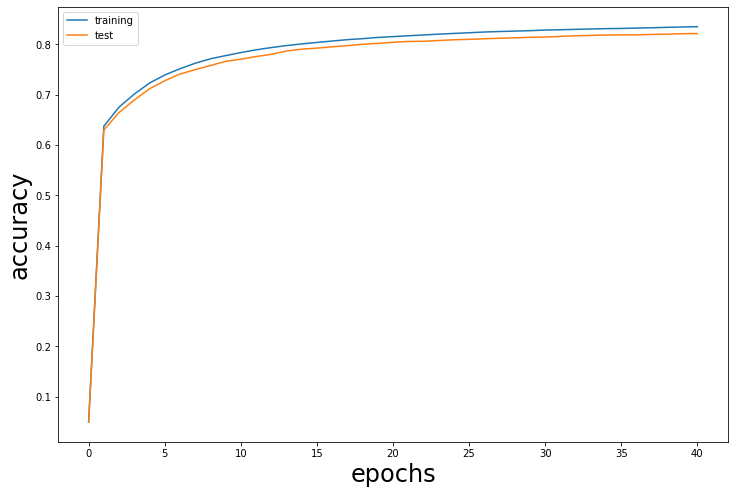

In [68]:
plt.figure(figsize=(12,8))
plt.xlabel('epochs', size=24)
plt.ylabel('accuracy', size=24)
plt.plot(accuracy_train,label='training')
plt.plot(accuracy_test,label = 'test')
plt.legend()
plt.show()


How we could expect the loss function is decreasing, and this (how we can see from the plots) happens for both the training and the testing set. In particular we can see that they have similar trend, decreasing really fast at first and then slowering a lot, and they seem to have a tendence to converge to a certain value. In particular we can also see how the loss function values are greater for the testing set than for the training, which is exactly what we would expect. However the difference is small enough to say that the model does not overfit to the training data, giving a good model can be reused (still as said before if we do not need better accuracy)

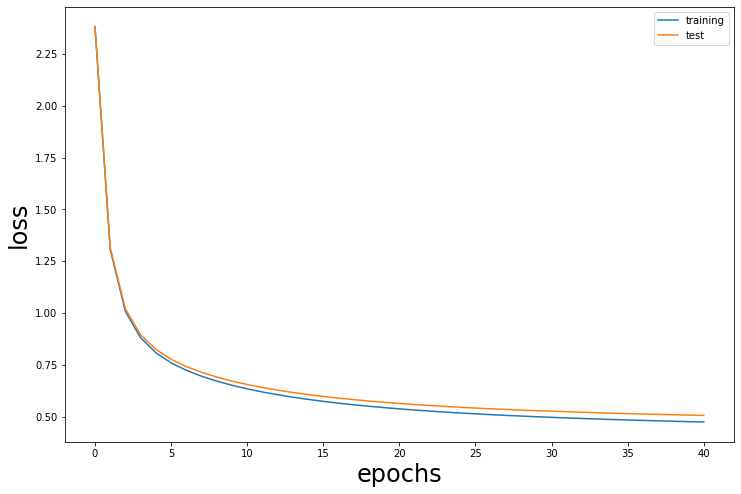

In [69]:
plt.figure(figsize=(12,8))
plt.xlabel('epochs', size=24)
plt.ylabel('loss', size=24)
plt.plot(loss_train,label = 'training')
plt.plot(loss_test,label = 'test')
plt.legend()
plt.show()

### 1.1.2

We repeat what we have done before with different learning rates. We start from a learning rate equal to $10^{-5}$

In [72]:
epochs = 40
learning_rate = 1e-5
network = network_parameter(X_train,400,10)
time0 = time.time()
network2, loss_train2, accuracy_train2, loss_test2, accuracy_test2 = training(X_train,y_train,X_test,y_test,epochs,learning_rate)
time1 = time.time()
print('timing',time1-time0)

accuracy on the training set 0.12786666666666666
epoch= 0
accuracy on the training set 0.133
epoch= 1
accuracy on the training set 0.13956666666666667
epoch= 2
accuracy on the training set 0.1471
epoch= 3
accuracy on the training set 0.1564
epoch= 4
accuracy on the training set 0.16856666666666667
epoch= 5
accuracy on the training set 0.1815
epoch= 6
accuracy on the training set 0.19651666666666667
epoch= 7
accuracy on the training set 0.21286666666666668
epoch= 8
accuracy on the training set 0.22728333333333334
epoch= 9
accuracy on the training set 0.24218333333333333
epoch= 10
accuracy on the training set 0.2558166666666667
epoch= 11
accuracy on the training set 0.26861666666666667
epoch= 12
accuracy on the training set 0.2814833333333333
epoch= 13
accuracy on the training set 0.2969833333333333
epoch= 14
accuracy on the training set 0.31371666666666664
epoch= 15
accuracy on the training set 0.3293333333333333
epoch= 16
accuracy on the training set 0.347
epoch= 17
accuracy on the tra

We can crearly see that as before the loss function decreases for both training and testing sets, but the trend seems to be slightly different. In fact we cannot see the 'fast decreasing' in the first part of the plot and a clear decrease in 'speed of decrease'. That's because we are taking too small steps in the sgd. This means that even  if the model gets better in time, it does it proceeding in general really slowly.

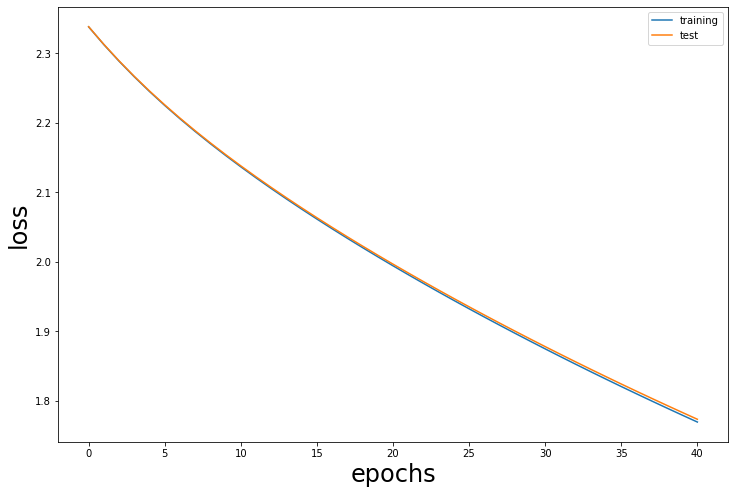

In [75]:
plt.figure(figsize=(12,8))
plt.xlabel('epochs', size=24)
plt.ylabel('loss', size=24)
plt.plot(loss_train2,label = 'training')
plt.plot(loss_test2,label = 'test')
plt.legend()
plt.show()

If we plot the accuracy this is even more evident. As a matter of fact we can see how the final accuracy we get is around $50\%$, which is clearly less than the one we got before. This means that maybe if we leave this model to run for a bigger number of epochs, being it 'prudent' (so proceeding with small steps) it can arrive to the same accuracies we got before, but for 40 epochs, it is not a good model

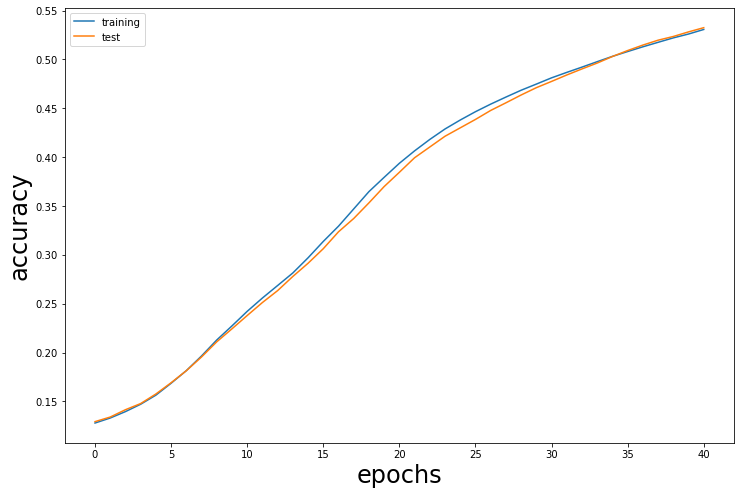

In [76]:
plt.figure(figsize=(12,8))
plt.xlabel('epochs', size=24)
plt.ylabel('accuracy', size=24)
plt.plot(accuracy_train2,label = 'training')
plt.plot(accuracy_test2,label = 'test')
plt.legend()
plt.show()

Trying to implement the model with $0.1$ as a learning rate, I encounter errors (mainly I divide by zero somewhere), but what I would expect to happen is to have an overfitting model, which seems to be good on the training set but with bad predictions on the testing set. Being also the learning rate too big, I would expect more fluctuations on the testing set accuracy and loss, so more intability in the 'growth' of the accuracy and in the 'decrease' of the loss.

However smaller for smaller learning rates, but still bigger than 0.001, we can still have really good result. We can prove that running the model for a learning rate equal to 0.08

In [94]:
epochs = 40
learning_rate = 0.08
network = network_parameter(X_train,400,10)
time0 = time.time()
network3, loss_train3, accuracy_train3, loss_test3, accuracy_test3 = training(X_train,y_train,X_test,y_test,epochs,learning_rate)
time1 = time.time()
print('timing',time1-time0)

accuracy on the training set 0.14376666666666665
epoch= 0
accuracy on the training set 0.7853666666666667
epoch= 1
accuracy on the training set 0.7976
epoch= 2
accuracy on the training set 0.81035
epoch= 3
accuracy on the training set 0.8192833333333334
epoch= 4
accuracy on the training set 0.8259666666666666
epoch= 5
accuracy on the training set 0.8304166666666667
epoch= 6
accuracy on the training set 0.8336666666666667
epoch= 7
accuracy on the training set 0.83585
epoch= 8
accuracy on the training set 0.8378
epoch= 9
accuracy on the training set 0.8394833333333334
epoch= 10
accuracy on the training set 0.8410833333333333
epoch= 11
accuracy on the training set 0.8421333333333333
epoch= 12
accuracy on the training set 0.8434166666666667
epoch= 13
accuracy on the training set 0.8447833333333333
epoch= 14
accuracy on the training set 0.84555
epoch= 15
accuracy on the training set 0.8466666666666667
epoch= 16
accuracy on the training set 0.8474
epoch= 17
accuracy on the training set 0.847

We can see how in this case the model is even faster in the beginning, and slows down converging after. However we can also notice that the distance between the testing and the training set is more evident in the plot, which can be a problem in terms of adaptability of the model. However in this specific case it still seems to be good

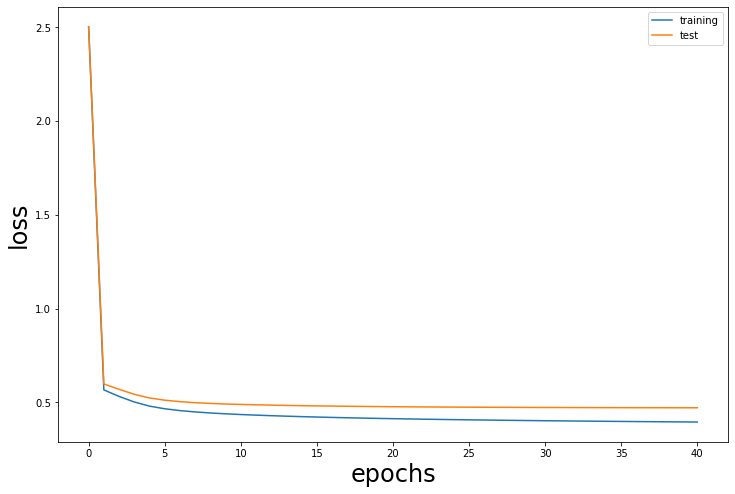

In [152]:
plt.figure(figsize=(12,8))
plt.xlabel('epochs', size=24)
plt.ylabel('loss', size=24)
plt.plot(loss_train3,label = 'training')
plt.plot(loss_test3,label = 'test')
plt.legend()
plt.show()

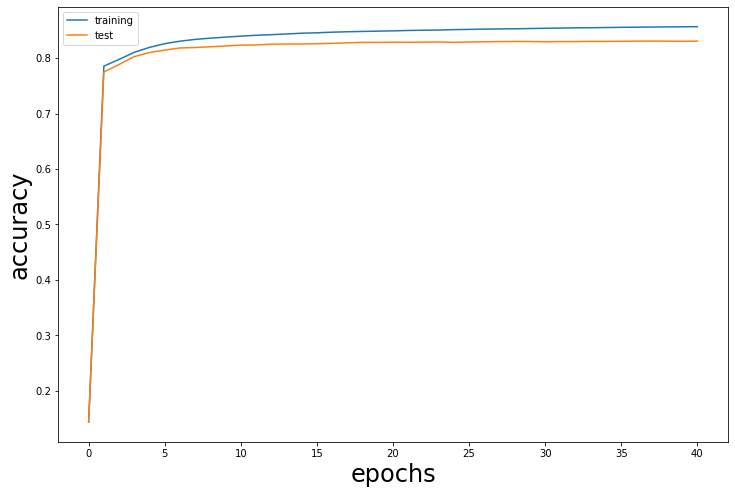

In [153]:
plt.figure(figsize=(12,8))
plt.xlabel('epochs', size=24)
plt.ylabel('accuracy', size=24)
plt.plot(accuracy_train3,label = 'training')
plt.plot(accuracy_test3,label = 'test')
plt.legend()
plt.show()

In [154]:
epochs = 40
learning_rate = 0.082
network = network_parameter(X_train,400,10)
time0 = time.time()
network3c, loss_train3c, accuracy_train3c, loss_test3c, accuracy_test3c = training(X_train,y_train,X_test,y_test,epochs,learning_rate)
time1 = time.time()
print('timing',time1-time0)

accuracy on the training set 0.14038333333333333
epoch= 0
accuracy on the training set 0.8278333333333333
epoch= 1
accuracy on the training set 0.8421833333333333
epoch= 2
accuracy on the training set 0.84815
epoch= 3
accuracy on the training set 0.8518833333333333
epoch= 4
accuracy on the training set 0.8545166666666667
epoch= 5
accuracy on the training set 0.85625
epoch= 6
accuracy on the training set 0.8573333333333333
epoch= 7
accuracy on the training set 0.8586666666666667
epoch= 8
accuracy on the training set 0.85965
epoch= 9
accuracy on the training set 0.8603
epoch= 10
accuracy on the training set 0.8609333333333333
epoch= 11
accuracy on the training set 0.8612333333333333
epoch= 12
accuracy on the training set 0.8614
epoch= 13
accuracy on the training set 0.8621166666666666
epoch= 14
accuracy on the training set 0.8624666666666667
epoch= 15
accuracy on the training set 0.8628833333333333
epoch= 16
accuracy on the training set 0.8632666666666666
epoch= 17
accuracy on the traini

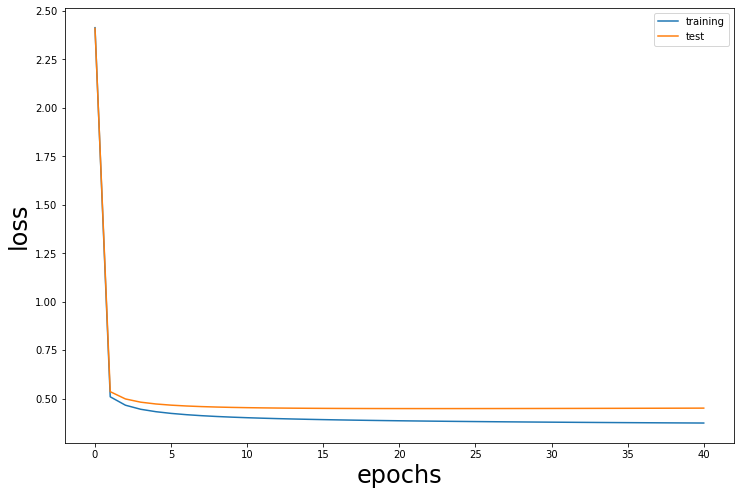

In [87]:
plt.figure(figsize=(12,8))
plt.xlabel('epochs', size=24)
plt.ylabel('loss', size=24)
plt.plot(loss_train3c,label = 'training')
plt.plot(loss_test3c,label = 'test')
plt.legend()
plt.show()

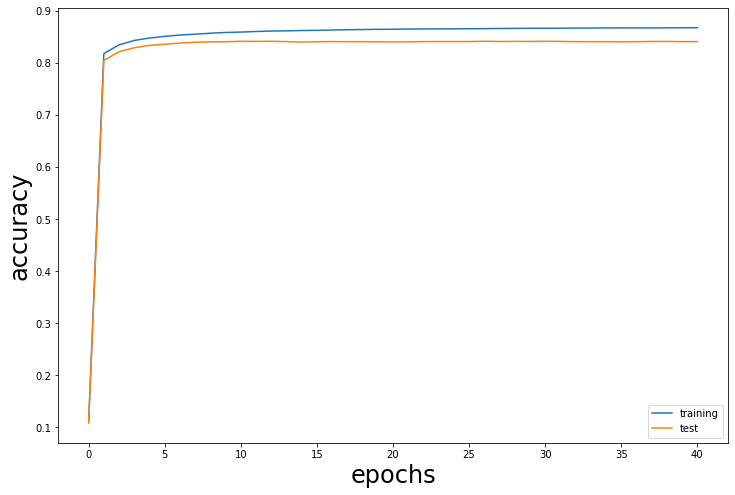

In [88]:
plt.figure(figsize=(12,8))
plt.xlabel('epochs', size=24)
plt.ylabel('accuracy', size=24)
plt.plot(accuracy_train3c,label = 'training')
plt.plot(accuracy_test3c,label = 'test')
plt.legend()
plt.show()

In [95]:
accuracy_test3c

[0.1082,
 0.8042,
 0.8211,
 0.8287,
 0.8333,
 0.8354,
 0.8376,
 0.8392,
 0.8399,
 0.8402,
 0.841,
 0.8409,
 0.8411,
 0.8405,
 0.8395,
 0.8402,
 0.8405,
 0.8403,
 0.8403,
 0.8401,
 0.8399,
 0.84,
 0.8405,
 0.8405,
 0.8406,
 0.8406,
 0.8411,
 0.8407,
 0.8409,
 0.8408,
 0.8411,
 0.8408,
 0.8404,
 0.8403,
 0.8403,
 0.8402,
 0.8403,
 0.8407,
 0.8408,
 0.8404,
 0.8405]

### 1.1.3

Now we repeat what we did before for $80$ epochs (still with learning rate equal to $0.001$)

In [74]:
epochs2 = 80
learning_rate = 0.001
network = network_parameter(X_train,400,10)
time0 = time.time()
network4, loss_train4, accuracy_train4, loss_test4, accuracy_test4 = training(X_train,y_train,X_test,y_test,epochs2,learning_rate)
time1 = time.time()
print('timing',time1-time0)

accuracy on the training set 0.04148333333333333
epoch= 0
accuracy on the training set 0.6355666666666666
epoch= 1
accuracy on the training set 0.67035
epoch= 2
accuracy on the training set 0.6939666666666666
epoch= 3
accuracy on the training set 0.716
epoch= 4
accuracy on the training set 0.73235
epoch= 5
accuracy on the training set 0.7451
epoch= 6
accuracy on the training set 0.7548833333333334
epoch= 7
accuracy on the training set 0.7644
epoch= 8
accuracy on the training set 0.7725166666666666
epoch= 9
accuracy on the training set 0.7791166666666667
epoch= 10
accuracy on the training set 0.7850166666666667
epoch= 11
accuracy on the training set 0.7905666666666666
epoch= 12
accuracy on the training set 0.7954
epoch= 13
accuracy on the training set 0.7986833333333333
epoch= 14
accuracy on the training set 0.8024833333333333
epoch= 15
accuracy on the training set 0.8049833333333334
epoch= 16
accuracy on the training set 0.8076333333333333
epoch= 17
accuracy on the training set 0.80998

We can see that the trends for both loss and accurcacy plot are the same we enocuntered in 1.1.1, where our number of epochs was $40$. So all the observation for that case are true also now. 

However even if in this case the model is slightly better, which we can see from the fact that we get a slightly better accuracy (for example for the training set is almost $85\%$), we can say that implementing MLP with 80 epochs is not worth it. As a matter of fact we can see that doing that does not provide any clear improvement compared to what we got previously with 40 epochs.

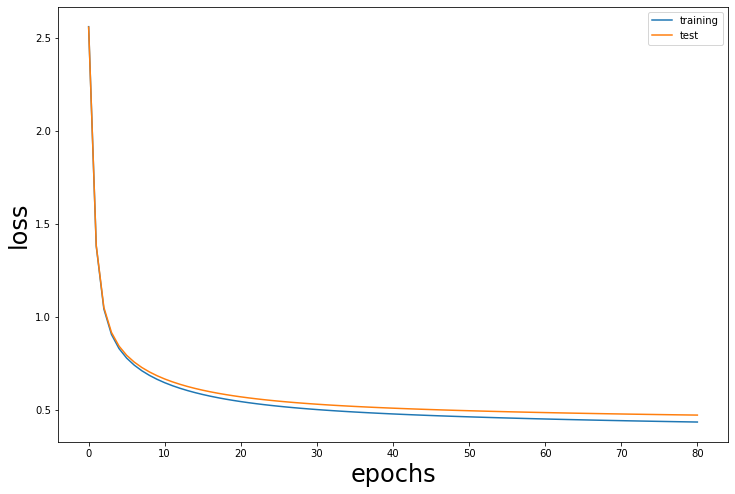

In [79]:
plt.figure(figsize=(12,8))
plt.xlabel('epochs', size=24)
plt.ylabel('loss', size=24)
plt.plot(loss_train4,label = 'training')
plt.plot(loss_test4,label = 'test')
plt.legend()
plt.show()

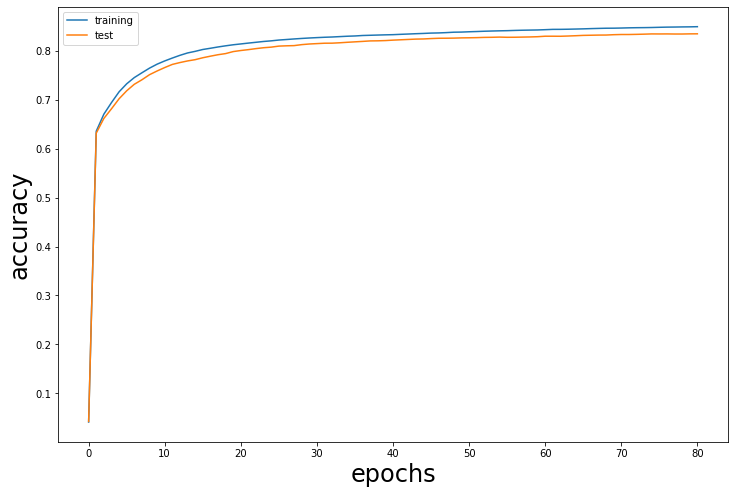

In [80]:
plt.figure(figsize=(12,8))
plt.xlabel('epochs', size=24)
plt.ylabel('accuracy', size=24)
plt.plot(accuracy_train4,label = 'training')
plt.plot(accuracy_test4,label = 'test')
plt.legend()
plt.show()

<a name="q12"></a>
## 1.2 Convolutional neural network (CNN) [^](#outline)

We import the data and the libraries we want to work with

In [4]:
#I import the data 
def load_data():
 (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
 x_train = x_train.astype('float32') / 255
 x_test = x_test.astype('float32') / 255
 # convert labels to categorical samples
 y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
 y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
 return ((x_train, y_train), (x_test, y_test))
(x_train, y_train), (x_test, y_test) = load_data()

In [5]:
#imporrting the libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D
import time

We add a dimension

In [6]:
#DO NOT RUN MORE THAN ONE TIME
x_train = np.expand_dims(x_train, axis=-1) 
x_test = np.expand_dims(x_test,axis=-1)
print(x_test.shape,x_train.shape)

(10000, 28, 28, 1) (60000, 28, 28, 1)


### 1.2.1

We want to build a CNN which takes as an input our samples images, which have all of them size $(28,28)$, which we will write as $(28,28,1)$.

We will use 4 convolutional layers, the first two with 8 feature maps/filters/channels, and the other with 16 filters, all of them of size (3,3).

Then we will have a (2,2) maximum pooling layer.

Finally we will include a fully connected layer with 64 neurons.

The output layer has 10 neurons.

We will use leakyrelu (defined using keras) for the hidden layers and softmax on the output layer.

The following is the code, strongly based on the library tensoflow and following the classical use suggested in the tensorflow library tutorial itself.

In [63]:
#we build the CNN
input_shape= (28,28,1) #the input shape
#now we use tensorflow sequential
convnet= Sequential([
        Conv2D(filters=8,kernel_size=(3,3), activation=keras.layers.LeakyReLU(alpha=0.01), input_shape=input_shape),
        Conv2D(filters=8, kernel_size=(3,3),activation=keras.layers.LeakyReLU(alpha=0.01)),
        Conv2D(filters=16, kernel_size=(3,3), activation=keras.layers.LeakyReLU(alpha=0.01)),
        Conv2D(filters=16, kernel_size=(3,3), activation=keras.layers.LeakyReLU(alpha=0.01)),  
        MaxPooling2D(pool_size=(2, 2)),   
        Flatten(),
        Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
        Dense(10, activation='softmax')
    ])
#learning rate
learning_rate = 0.001
#sgd from keras
opt= tf.keras.optimizers.SGD(lr=learning_rate, nesterov=False) #use SGD
convnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
convnet.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 24, 24, 8)         584       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 22, 22, 16)        1168      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 20, 20, 16)        2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)              

We will use 256 batches and 40 epochs. We time also the function

In [64]:
#train the model
batch_size = 256

#we also compute training time: 
time_0 = time.time()
#running
m = convnet.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=40, verbose=1,
                    validation_data=(x_test, y_test), shuffle=True)
time_1 = time.time()
print('Training time: ', time_1-time_0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 96s 2ms/sample - loss: 2.2822 - accuracy: 0.1301 - val_loss: 2.2581 - val_accuracy: 0.1487
Epoch 2/40
60000/60000 [==============================] - 94s 2ms/sample - loss: 2.2244 - accuracy: 0.1664 - val_loss: 2.1746 - val_accuracy: 0.2268
Epoch 3/40
60000/60000 [==============================] - 93s 2ms/sample - loss: 2.0446 - accuracy: 0.3445 - val_loss: 1.8110 - val_accuracy: 0.4376
Epoch 4/40
60000/60000 [==============================] - 96s 2ms/sample - loss: 1.3889 - accuracy: 0.5512 - val_loss: 1.0679 - val_accuracy: 0.6180
Epoch 5/40
60000/60000 [==============================] - 95s 2ms/sample - loss: 0.9444 - accuracy: 0.6719 - val_loss: 0.8772 - val_accuracy: 0.6858
Epoch 6/40
60000/60000 [==============================] - 96s 2ms/sample - loss: 0.8182 - accuracy: 0.7075 - val_loss: 0.8143 - val_accuracy: 0.7025
Epoch 7/40
60000/60000 [==============================] 

We can see that we get similar loss and accuracy to the one we got with MLP.

In particular see that the final accuracy for 40 epochs is roughly $81\%$ and $80\%$ (for training and test), which is slightly worse from the one we got for MLP with 40 epochs and learning rate of 0.001.
Plotting the losses and the accuracies, for both the training and the testing sets (following plots) we can see that also the trend seems to be similar to the ones we got for MLP (40 epochs and 0.001 rate), with higher speed of decrease/increase in the first part of the plot, and slower trends after, with a convergence tendency. However for the training set we can see that the plots seem to be 'smoother' in this case than with the MLP. On the other hand for the testing set we see some fluctuation we didn't notice before for MLP 40-0.001  

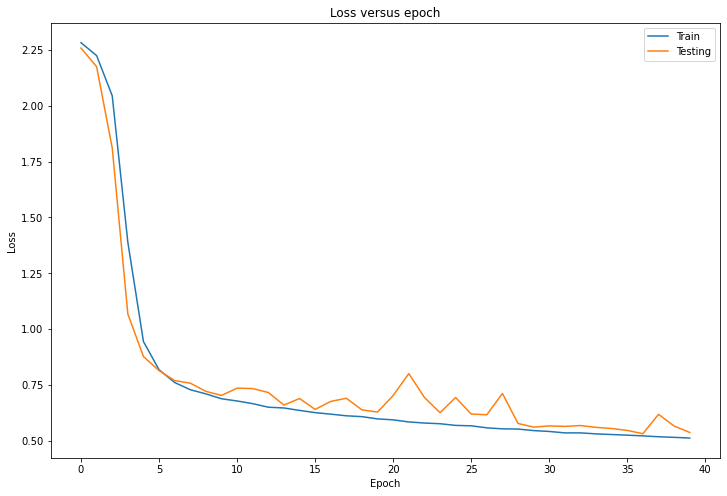

In [68]:
plt.figure(figsize=(12,8))
plt.plot(m.history['loss'], label='Train')
plt.plot(m.history['val_loss'], label='Testing')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss versus epoch")
plt.legend()

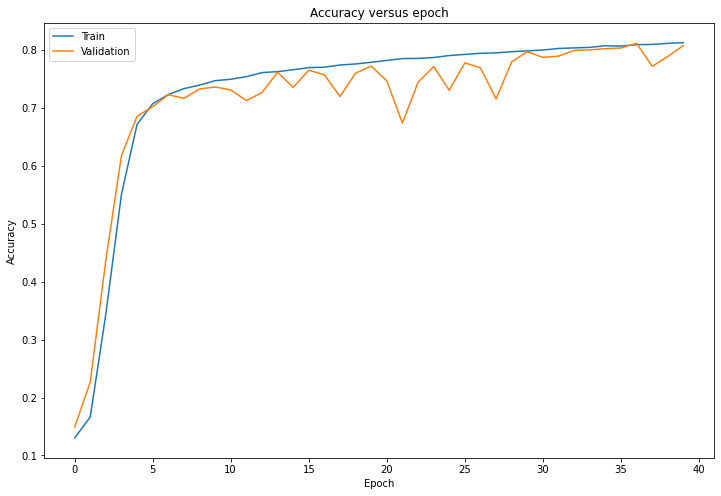

In [69]:
plt.figure(figsize=(12,8))
plt.plot(m.history['accuracy'], label='Train')
plt.plot(m.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy versus epoch")
plt.legend()

### 1.2.2

We split in validation and training set. Before I shuffle

In [7]:
#(from Knn notebook)
perm = np.random.permutation(len(y_train))
X_permuted_122 = x_train[perm]
y_permuted_122 = y_train[perm]

# we split train to test as 80:20
split_rate = 0.8
X_train_split, X_val = np.split(X_permuted_122, [int(split_rate*(X_permuted_122.shape[0]))])
y_train_split, y_val = np.split(y_permuted_122, [int(split_rate*(y_permuted_122.shape[0]))])

I define an array with all the probabilities

In [29]:
#I define the 
probabilities = 0.1*np.linspace(1,9,9)
probabilities

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In the following code I defined a dictionary (I decided to use dictionaries to have faster code), in which I stored the information gained implementing the CNN for different probability. In particular each element of the dictionary is a dictionary containing loss, accuracy for both training and validation sets. 
I store in the dictionaries the results I get implementing the CNN with different probabilities of dropout. I do that using a loop that training on 80% of the samples with a certain dropout probability and validates over 20% of the samples

In [30]:
#I define the loop
input_shape = (28,28,1)

dictionary_of_dictionaries = {} #I will store everything I get for each different probability 
lkrelu = keras.layers.LeakyReLU(alpha=0.01) #to implement it only ones outside the loop
for probability in probabilities:
    print('analizing probability=',probability)
    convnet = Sequential([
        Conv2D(filters=8,kernel_size=(3,3), activation=lkrelu, input_shape=input_shape),
        Conv2D(filters=8, kernel_size=(3,3),activation=lkrelu),
        Conv2D(filters=16, kernel_size=(3,3), activation=lkrelu),
        Conv2D(filters=16, kernel_size=(3,3), activation=lkrelu),  
        MaxPooling2D(pool_size=(2, 2)),   
        Flatten(),
        Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
        Dropout(probability),
        Dense(10, activation='softmax')
      ])
    #learning rate
    learning_rate = 0.001
    #sgd from keras
    opt = tf.keras.optimizers.SGD(lr=learning_rate, nesterov=False) #use SGD
    convnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    batch_size = 256

    #we also compute training time: 
    time_0 = time.time()
    
    with tf.device('/device:CPU:0'):
        m = convnet.fit(x=X_train_split, y=y_train_split, batch_size=batch_size, epochs=40, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
    time_1 = time.time()
    print('Training time: ', time_1-time_0)
    
    dictionary_of_dictionaries[str(probability)] = m.history

analizing probability= 0.1
Training time:  2857.088546037674
analizing probability= 0.2
Training time:  2908.97710108757
analizing probability= 0.30000000000000004
Training time:  2908.182362318039
analizing probability= 0.4
Training time:  2907.3125598430634
analizing probability= 0.5
Training time:  2938.450012922287
analizing probability= 0.6000000000000001
Training time:  2941.3081312179565
analizing probability= 0.7000000000000001
Training time:  2949.1036190986633
analizing probability= 0.8
Training time:  2947.553246974945
analizing probability= 0.9
Training time:  2956.09423494339


The process took roughly 7.5h!!!

In [33]:
dictionary_dropout = dictionary_of_dictionaries.copy()


m1,m2,... are dictionaries storing the loss, accuracy.. for both training and validation for different probabilities

In [39]:
m1 = dictionary_dropout[str(probabilities[0])]
m2 = dictionary_dropout[str(probabilities[1])]
m3 = dictionary_dropout[str(probabilities[2])]
m4 = dictionary_dropout[str(probabilities[3])]
m5 = dictionary_dropout[str(probabilities[4])]
m6 = dictionary_dropout[str(probabilities[5])]
m7 = dictionary_dropout[str(probabilities[6])]
m8 = dictionary_dropout[str(probabilities[7])]
m9 = dictionary_dropout[str(probabilities[8])]


In [41]:
m1

{'loss': [2.2972505162556964,
  2.2845282910664877,
  2.2643964201609292,
  2.219500165303548,
  2.0830022115707396,
  1.694921986579895,
  1.2964488646189372,
  1.1078358974456788,
  1.0095050967534382,
  0.9465719520250956,
  0.8952717995643615,
  0.8592414161364238,
  0.8225408930778504,
  0.8021000992457072,
  0.7789336452484131,
  0.7589492444992065,
  0.7415589323043823,
  0.7280323397318522,
  0.717073494275411,
  0.7047336951891581,
  0.6939952672322591,
  0.6848736821810405,
  0.6765391441980998,
  0.6722196963628133,
  0.6664954754511515,
  0.6569390185674031,
  0.6487566075325012,
  0.6449108667373658,
  0.6408611933390299,
  0.6331577655474345,
  0.6285455249150594,
  0.6269488671620687,
  0.6192767844200134,
  0.6151933288574218,
  0.6103942097028097,
  0.6077429049809774,
  0.6045136094093323,
  0.6007415456771851,
  0.5972630009651184,
  0.5916572558085124],
 'accuracy': [0.11227083,
  0.142625,
  0.15529166,
  0.18160416,
  0.26525,
  0.43160418,
  0.53347915,
  0.585,


Let's plot some of the accuracy on the validation set evolutions for different dropout probabilities versus the number of epoch. (0.1 and 0.7)

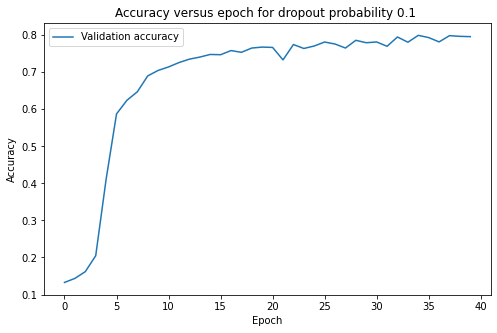

In [46]:
plt.figure(figsize=(8,5))
plt.plot(m1['val_accuracy'], label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy versus epoch for dropout probability 0.1 ")
plt.legend()

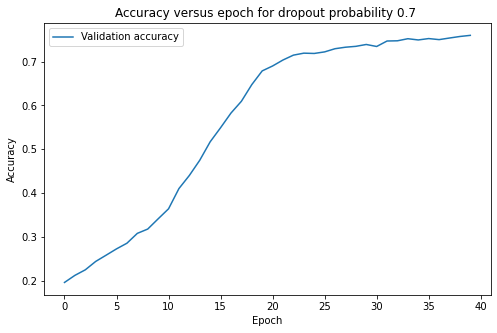

In [47]:
plt.figure(figsize=(8,5))
plt.plot(m7['val_accuracy'], label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy versus epoch for dropout probability 0.7 ")
plt.legend()

Let's now plot all of them. We can clearly see how some of them (like the one with probability p=0.9) perform really worse than the others 

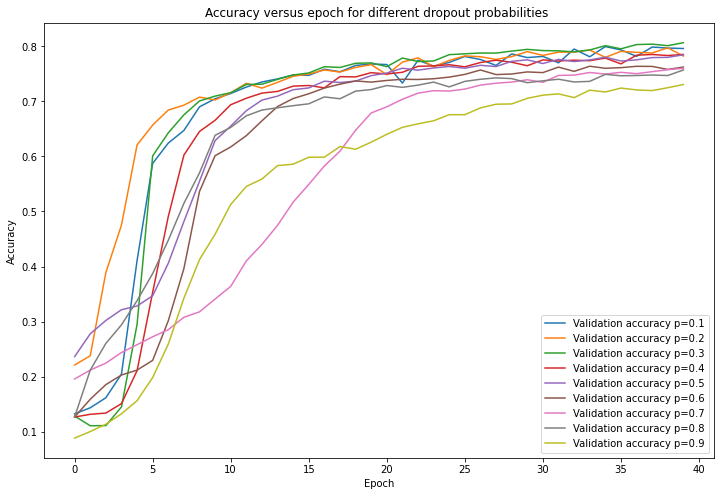

In [48]:
plt.figure(figsize=(12,8))
plt.plot(m1['val_accuracy'], label='Validation accuracy p=0.1')
plt.plot(m2['val_accuracy'], label='Validation accuracy p=0.2')
plt.plot(m3['val_accuracy'], label='Validation accuracy p=0.3')
plt.plot(m4['val_accuracy'], label='Validation accuracy p=0.4')
plt.plot(m5['val_accuracy'], label='Validation accuracy p=0.5')
plt.plot(m6['val_accuracy'], label='Validation accuracy p=0.6')
plt.plot(m7['val_accuracy'], label='Validation accuracy p=0.7')
plt.plot(m8['val_accuracy'], label='Validation accuracy p=0.8')
plt.plot(m9['val_accuracy'], label='Validation accuracy p=0.9')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy versus epoch for different dropout probabilities ")
plt.legend()

Let's fo the same with the losses

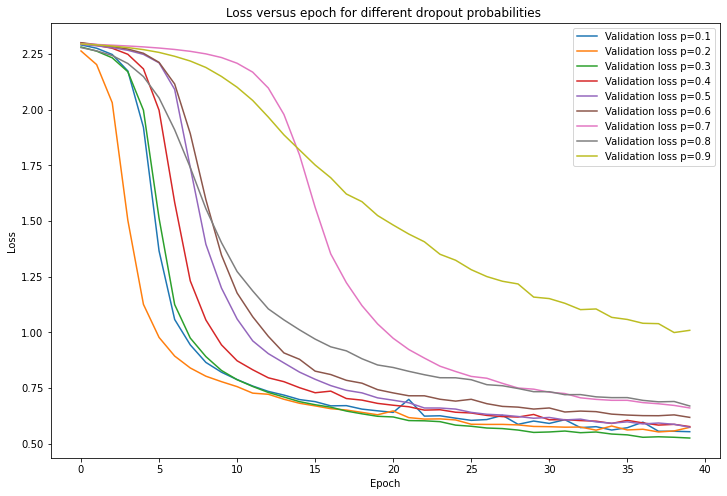

In [49]:
plt.figure(figsize=(12,8))
plt.plot(m1['val_loss'], label='Validation loss p=0.1')
plt.plot(m2['val_loss'], label='Validation loss p=0.2')
plt.plot(m3['val_loss'], label='Validation loss p=0.3')
plt.plot(m4['val_loss'], label='Validation loss p=0.4')
plt.plot(m5['val_loss'], label='Validation loss p=0.5')
plt.plot(m6['val_loss'], label='Validation loss p=0.6')
plt.plot(m7['val_loss'], label='Validation loss p=0.7')
plt.plot(m8['val_loss'], label='Validation loss p=0.8')
plt.plot(m9['val_loss'], label='Validation loss p=0.9')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss versus epoch for different dropout probabilities ")
plt.legend()

We can see how for each of them the accuracy seems to increase, so we are going to use the accuracy for 40 epochs to choose the best dropout probability.

Let's select the validation accuracy for 40 epochs for each probability

In [57]:
acc = []
acc.append(m1['val_accuracy'][39])
acc.append(m2['val_accuracy'][39])
acc.append(m3['val_accuracy'][39])
acc.append(m4['val_accuracy'][39])
acc.append(m5['val_accuracy'][39])
acc.append(m6['val_accuracy'][39])
acc.append(m7['val_accuracy'][39])
acc.append(m8['val_accuracy'][39])
acc.append(m9['val_accuracy'][39])
acc = np.array(acc)

In [60]:
acc

array([0.796     , 0.7823333 , 0.80658334, 0.78525   , 0.78466666,
       0.76233333, 0.7600833 , 0.757     , 0.7305833 ], dtype=float32)

I choose the max value of $\texttt{acc}$

In [59]:
np.argmax(acc)

2

Which is the one associated with probability 0.3 (Be aware that the index is 2 in the array acc, but the indices start from 0)

Now we train the CNN on the whole samples with dropout equal to 0.3 and check how well they perform on the testing set

In [61]:
#we build the CNN
input_shape = (28,28,1) #the input shape
#now we use tensorflow sequential
convnet = Sequential([
        Conv2D(filters=8, kernel_size=(3,3), activation=keras.layers.LeakyReLU(alpha=0.01), input_shape=input_shape),
        Conv2D(filters=8, kernel_size=(3,3), activation=keras.layers.LeakyReLU(alpha=0.01)),
        Conv2D(filters=16, kernel_size=(3,3), activation=keras.layers.LeakyReLU(alpha=0.01)),
        Conv2D(filters=16, kernel_size=(3,3), activation=keras.layers.LeakyReLU(alpha=0.01)),  
        MaxPooling2D(pool_size=(2, 2)),   
        Flatten(),
        Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
        Dropout(0.3),   #dropout of 0.3
        Dense(10, activation='softmax')
    ])
#learning rate
learning_rate = 0.001
#sgd from keras
opt = tf.keras.optimizers.SGD(lr=learning_rate, nesterov=False) #use SGD
convnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
convnet.summary()
batch_size = 256

#we also compute training time: 
time_0 = time.time()

m = convnet.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=40, verbose=1,
                    validation_data=(x_test, y_test), shuffle=True)
time_1 = time.time()
print('Training time: ', time_1-time_0)


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 24, 24, 8)         584       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 22, 22, 16)        1168      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 20, 20, 16)        2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)              

The dropout has a relevant effect in the training since it cuts off some neurons and in this way how highlighted in the lecture notes 'prevents hidden layers neurons from co-adaptation', providing a better model that should avoid overfitting phenomena.

ACCURACY AND LOSS
We plot now accuracy and loss. Compared to the case when we had no dropout we see similar trends and similar accuracy and loss values (in particular with 40 epochs we are still around $80\%$ as before). Even though in our case we can see that the dropout training accuracy and the loss have sightly worse results than the case without dopout, in general dropouts leads to very good results. 

In fact it helps to reduce the probability of an overfitting and so it leads to good prediction on other sets. We can see in fact that the difference between training and testing accuracy is not so big and that on the testing set the model seems to perform really well in terms of accuracy.

We can also notice less fluctuations on the testing set plot. 

Finally we can also notice how running the implementation of the model takes less time, than the time we needed to run the CNN without dropouts (3561.9385731220245 against 3891.1646027565002).

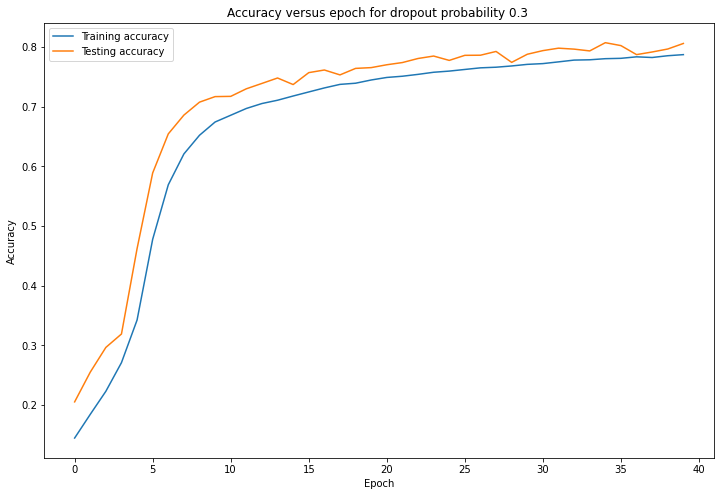

In [64]:
plt.figure(figsize=(12,8))
plt.plot(m.history['accuracy'], label='Training accuracy')
plt.plot(m.history['val_accuracy'], label='Testing accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy versus epoch for dropout probability 0.3 ")
plt.legend()

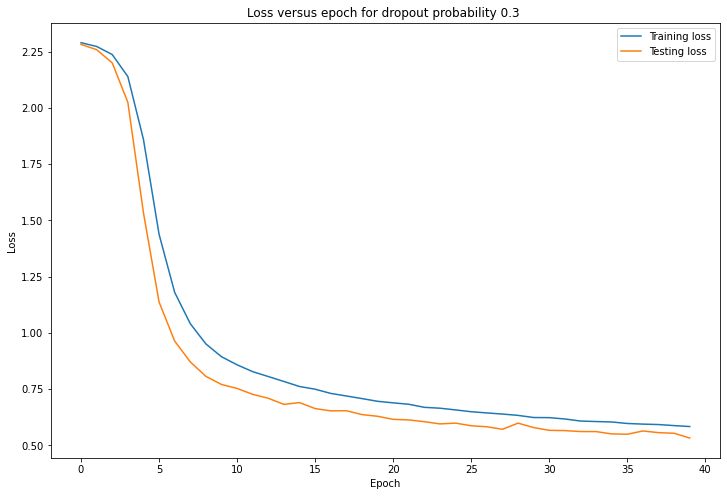

In [65]:
plt.figure(figsize=(12,8))
plt.plot(m.history['loss'], label='Training loss')
plt.plot(m.history['val_loss'], label='Testing loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss versus epoch for dropout probability 0.3 ")
plt.legend()

###### plotting the activations of the hidden units of the fully connected layer

I will import models from keras

In [204]:
from tensorflow.keras import models

In [205]:
#I identify the activations of the hidden fully connected layer
activation_fullyconnected = convnet.layers[6].output
#I use models from keras
activation_fully = models.Model(inputs = convnet.input,outputs = activation_fullyconnected)

In [206]:
activa1 = activation_fully.predict(x_test)

I use a heatmap to show how the magnitude of the activations for the testing set for the fully connected hidden layer.

The dimension is going to be 10000x64 (10000 as the testing samples, and 64 as the number of nodes of the layer we are considering).

The heatmap clearly evidentiate a sparsity. Having output values between 0 and roughly 23, the majority of them are really small

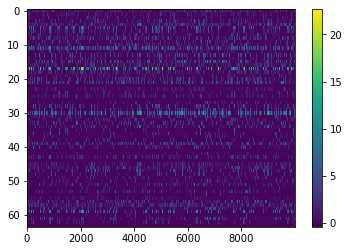

In [207]:
plt.imshow(activa1.T, interpolation = 'nearest', aspect = 'auto',cmap='viridis')
plt.colorbar()

We categorize the elements in 25 classes between 0 and 25, where in each class we count the number of outputs in that class. For example a class could be the number of elements with value in $[2,3]$

In [228]:
sp1 = np.linspace(0,24,25)
act1 = []
for j in range(len(sp1)):
    count = 0
    for i in range(activa1.shape[0]):
        for k in range(activa1.shape[1]):
            if j == 0 :
                if activa1[i,k]<sp[j]:
                    count+=1
            else:
                if activa1[i,k]>sp1[j-1] and activa1[i,k]<sp1[j]:
                    count+=1
    act1.append(count)



In [229]:
len(act1)

25

In [230]:
pf3r = np.arange(0,25,1)

<BarContainer object of 25 artists>

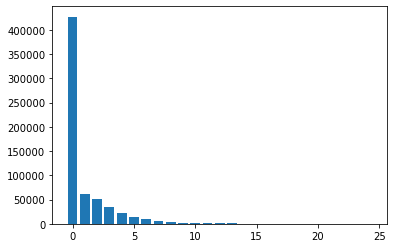

In [231]:
plt.bar(pf3r,act1)

The sparsity is even more clear in the plot above, where we see that the major concentration of activation outputs corresponds to the activation outputs with small values

Just for curiosity we can repeat the process for the final output of the Convolutional net

In [201]:
activation_output_layer = models.Model(inputs = convnet.input,outputs = convnet.output)

In [202]:
activa = activation_output_layer.predict(x_test)

A certain level of sparsity is noticeable also here

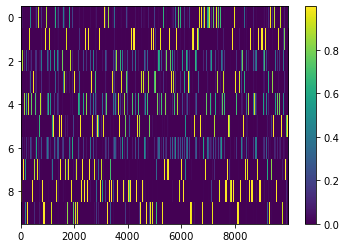

In [203]:
plt.imshow(activa.T, interpolation = 'nearest', aspect = 'auto',cmap='viridis')
plt.colorbar()

In [232]:
sp = np.linspace(0,1.1,25)
act = []
for j in range(len(sp)):
    count = 0
    for i in range(activa.shape[0]):
        for k in range(activa.shape[1]):
            if j == 0 :
                if activa[i,k]<sp[j]:
                    count+=1
            else:
                if activa[i,k]>sp[j-1] and activa[i,k]<sp[j]:
                    count+=1
    act.append(count)


In [233]:
act =np.array(act)
act

array([    0, 79263,  3036,  1921,  1538,  1306,  1064,   917,   764,
         668,   546,   530,   450,   428,   399,   374,   367,   400,
         407,   478,   565,   933,  3646,     0,     0])

In [234]:
pf4r = np.arange(0,25,1)

Note that in the following the scale on x axis should be from 0 to 1 and not from 0 to 25, but the pattern is the sam

<BarContainer object of 25 artists>

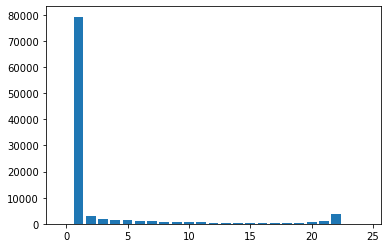

In [235]:
plt.bar(pf3r,act)

### 1.2.3

In [ ]:
def network_parameter(x,hidden_layer_nodes,output_nodes):
    dictionary = {} #we initialize a dictionary in which we will store weights and biases
    M,N = x.shape #N is the number of input neurons
    #weights
    dictionary['W1'] = np.random.randn(N,hidden_layer_nodes)/np.sqrt(N)
    dictionary['W2'] = np.random.randn(hidden_layer_nodes,hidden_layer_nodes)/np.sqrt(hidden_layer_nodes)
    dictionary['W3'] = np.random.randn(hidden_layer_nodes,hidden_layer_nodes)/np.sqrt(hidden_layer_nodes)
    dictionary['W4'] = np.random.randn(hidden_layer_nodes,hidden_layer_nodes)/np.sqrt(hidden_layer_nodes)
    dictionary['W5'] = np.random.randn(hidden_layer_nodes,hidden_layer_nodes)/np.sqrt(hidden_layer_nodes)
    dictionary['W6'] = np.random.randn(hidden_layer_nodes,output_nodes)/np.sqrt(hidden_layer_nodes)
    
    #biases
    dictionary['b1'] = np.zeros((1,hidden_layer_nodes))
    dictionary['b2'] = np.zeros((1,hidden_layer_nodes))
    dictionary['b3'] = np.zeros((1,hidden_layer_nodes))
    dictionary['b4'] = np.zeros((1,hidden_layer_nodes))
    dictionary['b5'] = np.zeros((1,hidden_layer_nodes))
    dictionary['b6'] = np.zeros((1,output_nodes))
    return dictionary

We see that this is the structure of our MLP, we defined in the first exercise. We remind that the input dimension was 784, the output 10 and we have 5 hidden layers with 400 nodes. We have 6 couples $(W_i,b_i)$, where we remember them being with dimension $(784,400)$ (for $W_1$), $(400,400)$, for i from 2 to 5 and $(400,10)$ the last one. The biases are all arrays long $400$, except from the last one which is $10$. So at the end the number of parameters is going to be:

In [238]:
n_parameters_MLP = 784*400+4*(400*400)+(400*10)+5*400+10
print('the number of parameters for MLP is', n_parameters_MLP)

the number of parameters for MLP is 959610


For what we've seen before the number of total parameters of the CNN with dropout is:

Total params: 107,266

(Which is calculated directly from tensorflow and can be seen directly from the previous printout) 

In [240]:
ratio = 959610/107266
ratio

8.946077974381444

As we've seen before the accuracies for the CNN and for the MLP are really similar (both around $80\%$ for 40 epochs, precisely $\approx 80.06\%$ and $\approx 82.2\%$ ), even though CNN has way less parameters.
(The precise accurancies for 40 epochs can be founded in the previous exercises)

In particular the number of parameters for the MLP is $8.946077974381444$ the number of the parameters of the CNN.

So we can conclude that CNN is more memory efficient and also that its structure is more functional to this kind of use in image classification.


### 1.2.4

We plot one of the images of the set, which seems to be a shoe

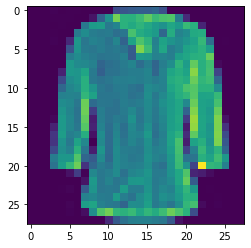

In [377]:
plt.imshow(x_test[4])

I use the libraries introduced in ex1.2.2 and the same ideas to extract the outputs for the convolutional layers

In [348]:
exp1 = convnet.layers[0].output
exp2 = convnet.layers[1].output
exp3 = convnet.layers[2].output
exp4 = convnet.layers[3].output
activation_exp1 = models.Model(inputs = convnet.input,outputs = exp1)
activation_exp2 = models.Model(inputs = convnet.input,outputs = exp2)
activation_exp3 = models.Model(inputs = convnet.input,outputs = exp3)
activation_exp4 = models.Model(inputs = convnet.input,outputs = exp4)


I pass the testing set. a1, a2, a3, a4 represent each one the effects of the filters associated to the 4 convolutional layers

In [350]:
a1 = activation_exp1.predict(x_test)
a2 = activation_exp2.predict(x_test)
a3 = activation_exp3.predict(x_test)
a4 = activation_exp4.predict(x_test)

I check the size

In [352]:
print(a1.shape,
a2.shape,
a3.shape,
a4.shape)

(10000, 26, 26, 8) (10000, 24, 24, 8) (10000, 22, 22, 16) (10000, 20, 20, 16)


We now check various filter and give some hints about how they act in practive

I try the second filter (out of 8) of the first layer. I get the figure below, that shows how this filter detects the lower ends of the sleevs of the shirt

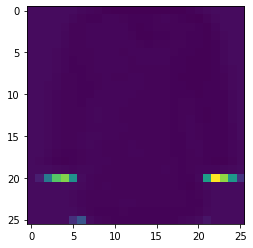

In [378]:
plt.imshow(a1[4,:,:,2])

I try the the 4th filter (out of 8) of the second layer and I see that it gives an approximate border of the hole shirt

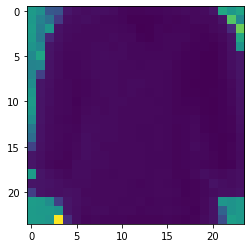

In [385]:
plt.imshow(a2[4,:,:,4])

I plot the result of the 5th filter (out of 16) of the 3th layer. We can see that it evidentiate the left border of the shirt

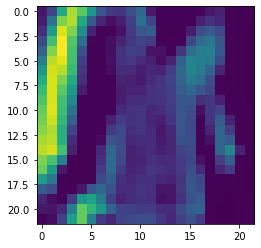

In [435]:
plt.imshow(a3[4,:,:,4])

I plot the result of the 11th filter (out of 16) of the 4th layer. We can see that it evidentiate the right border of the shirt

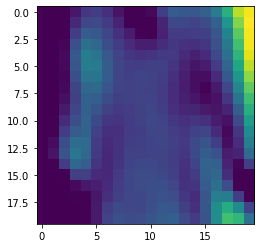

In [430]:
plt.imshow(a4[4,:,:,11])

<a name="task-2"></a>

# Task 2: Unsupervised learning [^](#outline)

<a name="q21"></a>

## 2.1 Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data [^](#outline)

We import the data again

In [509]:
#I import the data 
def load_data():
 (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
 x_train = x_train.astype('float32') / 255
 x_test = x_test.astype('float32') / 255
 # convert labels to categorical samples
 y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
 y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
 return ((x_train, y_train), (x_test, y_test))
(x_train, y_train), (x_test, y_test) = load_data()

We take the firs 1000 samples

In [459]:
X_211 = x_train[:1000]
X_211.shape

(1000, 28, 28)

### 2.1.1

We nee to normalize and centre the data, which basically means that we need to standardise

In [460]:
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

We flatten, in order to have 784 elements-long arrays as an input

In [463]:
X_standard = standardise(X_211)


X_train_PCA = []
for i in range(X_standard.shape[0]):
    X_train_PCA.append(X_standard[i].flatten())
    
X_train_PCA = np.array(X_train_PCA)
X_train_PCA.shape

X_train_PCA.shape

(1000, 784)

We implement the PCA function (taken from the weekly notebooks)

In [464]:
from scipy.sparse import linalg

def pca_function(X,k):

    # create covariance matrix S
    C = 1.0/(len(X)-1) * np.dot(X.T, X) 


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors) 

    return X_pca, eigenvectors, eigenvalues

We want 25 principle components, so we assign k=25 and compute the PCA. We check that $\texttt{x_pca}$ has the requested dimension (1000,25)

In [469]:
# choose our number of principle components
k = 25


# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X_train_PCA,k) 
X_pca.shape

(1000, 25)

### 2.1.2

We print and plot a scatter of the eigenvalues, as requested. From the values and the plots(below) we note that we are in the so called 'ideal situation' of the notes. In fact the first 2 eigenvalues are really large and we have really smaller values after that. This leads to think of $m=2$ as a good choice.


In [475]:
eigenvalues

array([175.66086  , 111.62361  ,  43.4967   ,  41.184517 ,  31.487581 ,
        25.323772 ,  21.559633 ,  19.177723 ,  13.931772 ,  11.404521 ,
         9.759374 ,   8.921597 ,   8.482834 ,   7.3857555,   6.8686523,
         6.2997737,   5.340354 ,   5.1096025,   4.99623  ,   4.842248 ,
         4.494605 ,   4.3852315,   4.141928 ,   3.9076033,   3.6930125],
      dtype=float32)

In [552]:
eigsct = np.arange(0,25,1) #used just to scatter easily

Text(0.5, 0, 'm')

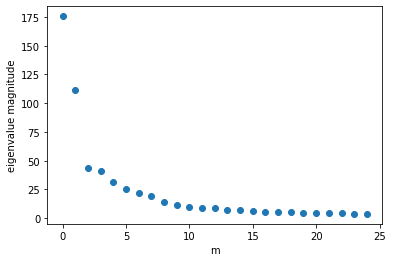

In [551]:
plt.scatter(eigsct,eigenvalues)
plt.ylabel('eigenvalue magnitude')
plt.xlabel('m')

We calculate now the fraction of explained variance as m is increased and plot it, seeing that it has a similar trend like the eigenvalues

In [482]:
C = 1.0/(len(X_train_PCA)-1) * np.dot(X_train_PCA.T, X_train_PCA)
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

explained_variances = eigenvalues /  total_variance ## <-- SOLUTION
print('The explained variance for the first 25 principle components is: {}'.format(explained_variances))

The explained variance for the first 25 principle components is: [0.22469299 0.14278105 0.05563791 0.05268033 0.0402767  0.03239238
 0.02757756 0.02453079 0.01782054 0.01458786 0.0124835  0.01141188
 0.01085064 0.00944734 0.0087859  0.00805823 0.006831   0.00653584
 0.00639083 0.00619386 0.00574918 0.00560928 0.00529806 0.00499833
 0.00472384]


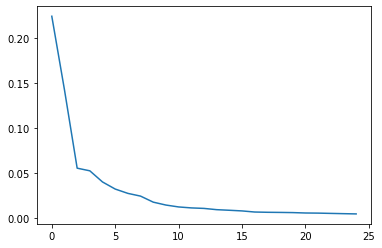

In [483]:
plt.plot(explained_variances)

Now we sum cumulatively them at each step to see if we go over 80%. In fact following the notes we know that ideally we would aim to reach in this way a cumulated sum of 80%.

In [484]:
list_of_exp_cumulated = []
cumulated = 0
for i in range(len(explained_variances)):
    cumulated+=explained_variances[i]
    list_of_exp_cumulated.append(cumulated)



Now we plot the cumulated sums

Text(0, 0.5, 'cumulated sum of fraction of explained variance ')

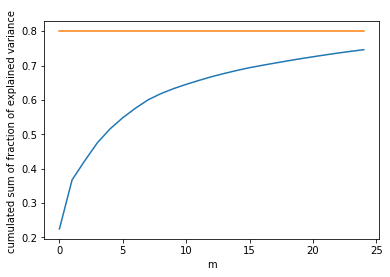

In [553]:
plt.plot(list_of_exp_cumulated)
plt.plot(eigsct,0.8*np.ones(len(eigsct)))
plt.xlabel('m')
plt.ylabel('cumulated sum of fraction of explained variance ')

We see that we do not reach the 80% with m=25, but as said before we are in an ideal case with a fast dropout of value after the second eigenvalue, so we can conclude that a good m is m=2. (for which we have already a good percentage in the previous plot (almost 0.4, so 40%), and the fastest growth is associated)

Moreover this choice of m we have also a really good advantage, which is the fact thay with only 2 principal components it is easy for us to have a practical view about what is happening.

### 2.1.3

Now we take $m=2$, and implement our code

In [491]:
k2 = 2


# compute the projection, the eigenvector and eigenvalues from our function
X_pca2, eigenvectors2, eigenvalues2 = pca_function(X_train_PCA,k2) 
X_pca2.shape

(1000, 2)

We define also the possible classes of our samples, considering the first 1000 samples of y_train, considering the position of the non zero component of each sample array. Finally we proceed associating together in the same class the samples with the same position of the non zero (=1) component. We will have 10 different classes

In [540]:
classes_of_train = []
for j in range(1000):
    classes_of_train.append(np.argmax(y_train[j]))

Finally we scatter our samples and colour accordingly with the associated classes given before. We do not focus in what each class represent in our dataset, since it is not requested. However we can do many important observations. We can see how overall the classes are decently 'classified/clustered'. In particular this is really evident for the orange class (on the bottom of the plot), the purple one and the light blue (on the right). For the other classes the 'classification/clustering' is not so evident, cause we see more dispersion, but we can still say that the process overall produces good results

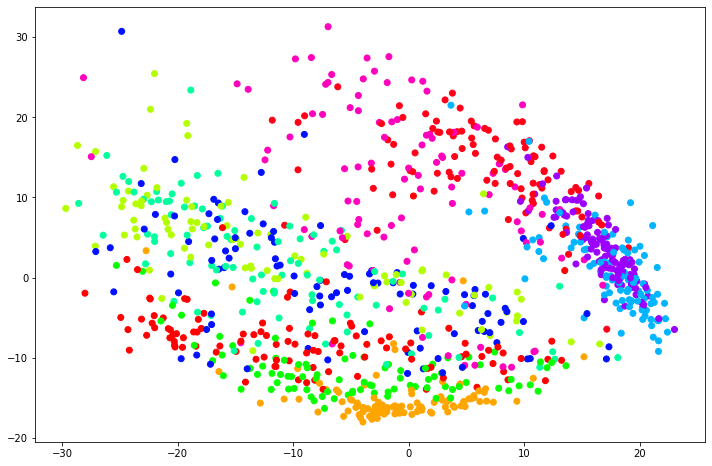

In [550]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(X_pca2[:,0],X_pca2[:,1],c = classes_of_train,cmap='hsv')
plt.show()


### 2.1.4

We define the k-means function, which takes as an input the data and k.
Between the outputs there is also the distance W (defined in the notes), which will be used to determine the best k.

In [669]:
def kmeans(X,k):
    n_samples, n_features = X.shape
    # labels: assign every sample to a cluster at random
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    
    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:2]  
    
    max_iter = 350
    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)
        
        #calculation of W
        W = distances[new_labels[0],0]
        for j in range(1,n_samples):
            elem = distances[new_labels[j],j]
            W += elem
        if (labels==new_labels).all():

            # labels unchanged
            labels = new_labels
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)    
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X_pca2[labels==c], axis=0)    
    return W/2, centroids, labels

We run the code for k from 2 to 10 and evaluate the value of W and plot what we get

In [670]:
list_of_W = []
for j in range(2,11):
    W,cent,lab = kmeans(X_pca2,j)
    list_of_W.append(W)


Text(0, 0.5, 'W')

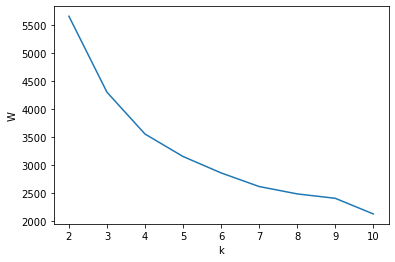

In [671]:
plt.plot(np.arange(2,11,1),list_of_W)
plt.xlabel('k')
plt.ylabel('W')

It is a good idea to choose the k corresponding to the elbow of the curve, which is $k=5$, as increasing k more than that does not bring relevant improvements.
We check that the best k we found does not correspond to the number of classes 10

In [651]:
W,cen,labels = kmeans(X_pca2,5)

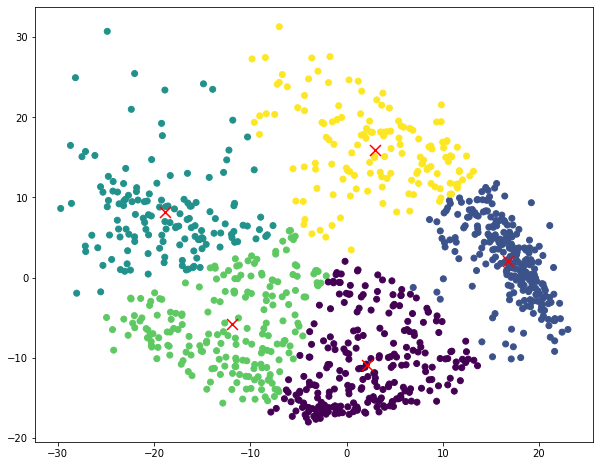

In [652]:
plt.figure(figsize=(10,8))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels);
plt.scatter(cen[:, 0], cen[:, 1], c='red', marker='x', s=120);

We can interpret what we got as follows:
Having only two principal components we could not have enough power to determine some borderline situations and distingush in same kind of situation. So giving less classes could be a way to have more generalizable model, which could in theory classify our samples in more generic macro classes instead of going in detail (for example with 10 classes which could generate errors).

<a name="q22"></a>

## 2.2 Clustering of the feature matrix [^](#outline)

We import the data and visualize

In [1]:
import pandas as pd
import numpy as np
names = pd.read_csv('dolphin_names.csv')
A = np.load('dolphins_A_62x62.npy')
F = np.load('dolphins_F_62x32.npy')

In [679]:
names

,Unnamed: 0,name
0,0,Beak
1,1,Beescratch
2,2,Bumper
3,3,CCL
4,4,Cross
...,...,...
57,57,Web
58,58,Whitetip
59,59,Zap
60,60,Zig


In [704]:
print('A=',A)
print('F=',F)

A= [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
F= [[-0.6954558  -0.1755044   0.5597173  ... -0.7036415   0.33274
   0.6067554 ]
 [ 0.03212426 -0.1478359   0.40415418 ... -0.13144329 -0.06645685
   0.02881631]
 [-0.46629754 -0.31022158  0.7977163  ... -0.11418673  0.4184413
  -0.24156176]
 ...
 [-0.37678945 -0.36206096  0.7815159  ... -0.11827335 -0.57978976
   0.38821217]
 [-0.09189968 -0.60944355 -0.52622736 ... -0.22533199 -0.62491184
  -0.4715202 ]
 [-0.15893078 -0.81560934  0.92142653 ... -0.02311835  0.16911532
  -0.06200394]]


### 2.2.1

We define a function calculating the euclidian distances

In [164]:
def pairwise_distances(points):
    '''
    Args:
        points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
    Returns:
        A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
    '''
    N, D = points.shape
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())    
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

We compute the distances

In [165]:
pairwise_dist = pairwise_distances(F)

We define the average linkage

In [166]:

def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    Args:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Returns:
      The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()   



We finally define the hierarchical clustering function

In [167]:
def hierarchical_clustering(points, distances, linkage):
    """
    The hierarchical clustering algorithm start with every point as a single cluster and 
    each iteration merges two clusters into one. We may wish to store all the 
    intermediate clustering results with respect to the number of clusters left.

    Args:
     points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
     A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The first row, i.e. a[0, :], represents the highest level of clustering where all columns have the same index value.
     The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
     The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """ 
    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        if (level % 10) == 0:
            print(f'level:{level}')
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = linkage(distances, current_assignment, cluster_i, cluster_j)    
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
                    
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment
        
    return assignments

In [168]:
acl = hierarchical_clustering(F, pairwise_dist, average_linkage)

level:60
level:50
level:40
level:30
level:20
level:10


We now print a sequence of the levels showing the evolution of the clustering.

(So we print from the finest level (which in my interpretation of the term finest is the one with 'more different clusters', to the coarsest (where in my interpretation coarsier means having less clusters and so 'more element agglomerated together')

In [169]:
acl2 = acl[1:,:]
for j in reversed(range(len(acl2))):
    print(61-j,'lev=' )
    print(acl[j,:])

1 lev=
[ 0.  1.  2.  3. 63.  5.  6.  7.  8.  9. 10. 63. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]
2 lev=
[ 0.  1.  2.  3. 63.  5.  6.  7.  8. 64. 10. 63. 12. 64. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]
3 lev=
[ 0.  1.  2.  3. 63. 65. 65.  7.  8. 64. 10. 63. 12. 64. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61.]
4 lev=
[ 0.  1.  2.  3. 63. 66. 66.  7.  8. 66. 10. 63. 12. 66. 14. 15. 16. 17.
 18. 19. 20. 21. 62. 23. 24. 25. 26. 27. 28. 29. 30. 62. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52

We can also 'plot' a heatmap representing what is happening. We see that in the first row we have a lot of different colors, and going down through the rows we see the 'merging process' leading to a final unique color at the last row representing the fact that (proceeding in the order we decided before) we have an agglomerative behaviour.

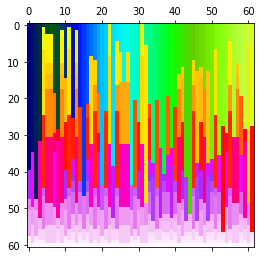

In [823]:
acl3 = np.flip(acl2,axis=0)
plt.matshow(acl3,cmap ='gist_ncar')

### 2.2.2

In this task we want to check how good the clustering is, and we will do that using the silhouette score, defined as the mean over the various samples of the silhouette coefficient, defined as $SC = \frac{d_2-d_1}{max(d_1,d_2)}$. 

We have that $d_1$ is the average distance between a sample and the cluster points, while $d_2$ the one between the point and the points of the nearest cluster

We notice that the coefficient is always in $[-1,1]$. In particular when we have all the samples in one unique cluster we will have $d_2=0$, which means that the coefficient is going to be -1 for all the samples and so the average is going to be -1. 
On the other hand if each element constitutes a sample we will have that $d_1=0$, and the coefficient is 1 for all the samples and so the score will also be 1.

In [1048]:
#We define d1
def d1(X,F,sample_index,pairwise_dist):
    #sample_index is the sample index on F
    d = np.zeros(X.shape[0])
    for i in range(X.shape[0]): #going through the levels
        d1 = 0
        count = 0
        for j in range(X.shape[1]): #going through the element of each row
            if X[i,j]==X[i,sample_index]: #finding the element of the same cluster
                d1 += pairwise_dist[j,sample_index] #summing the distances 
                count +=1
        if count>0:
            d1 = d1/count #mean (I am counting also the sample itself)
        d[i] = d1
    return d   

In [1058]:
#We define d2
def d2(X,F,sample_index,linkage,distances):
  D = np.zeros(X.shape[0])  
  for k in range(X.shape[0]):  
    #basing our code on a part of the hierarchical_clustering function we find the nearest cluster
    cluster_ind = X[k,sample_index]
    cluster_ids = np.unique(X[k,:])
    min_d = np.inf        
    # Initialize the cluster ids to be merged in this iteration.
    cluster_a = -1
    for i in range(cluster_ids.size):
        cluster_i = cluster_ids[i]
        if cluster_i != cluster_ind:
            d = linkage(distances, X[k,:], cluster_i, cluster_ind)    
            if d < min_d:
                min_d = d
                cluster_a= cluster_i
    d2 = 0
    count = 0
    for j in range(X.shape[1]):
        if X[k,j] == cluster_a:
            d2 += distances[j,sample_index]
            count += 1
    if count>0:
            d2 = d2/count 
    D[k] = d2
  return D
             
            
    

Let's now define the function for the Silhouette Score SSc

In [1072]:
def SSc(X,F,pairwise_dist,linkage,distances):
    SSc = np.zeros(62)
    for k in range(62):
        d_1 = d1(X,F,k,distances)
        d_2 = d2(X,F,k,linkage,distances)  
        SC_ = np.zeros(62)
        for j in range(X.shape[0]):
            SC1 = (d_2[j]-d_1[j])/max(d_1[j],d_2[j])
            SC_[j] = SC1
        SSc += SC_
    return SSc/62

In [1073]:
SSc = SSc(acl3,F,pairwise_dist,average_linkage,pairwise_distances(F))

We plot the evolution of the score depending on the level, from the finest, to the coarsest.

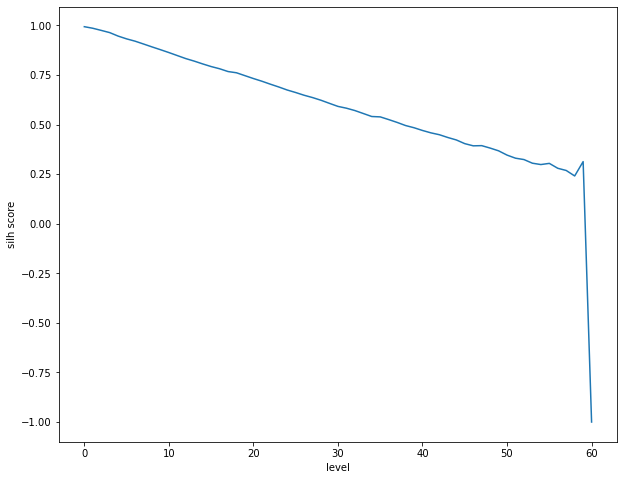

In [1075]:
plt.figure(figsize=(10,8))
plt.ylabel('silh score')
plt.xlabel('level')
plt.plot(SSc[:61])

We can see how as we were expecting the silhouette score is max maximized at the finest level (the first one), and that when we consider only one giant cluster containing everything we have -1.

(So to be more clear the level order is inverted, so we are going from the level with more clusters (which seems to be the best) to the one with only one cluster)

<a name="q23"></a>

## 2.3 Graph-based analysis  [^](#outline)

### 2.3.1

Given the adjacency matrix A (shown below)

In [23]:
print(A)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


We compute the Laplacian $L=D-A$, where D represents the diagonal matrix of the node degrees. Then we compute also the normalized Laplacian ($L = I-D^{-1/2}AD^{-1/2}$) 

In [24]:

# define diagonal matrix of node degrees
weighted_degree = A.sum(axis=1) 

# create diagonal matrix of degree
D = np.diag(weighted_degree)


# define Laplacian
L = D-A 

# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

#we print it
print(L_norm)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ...  0.          0.
  -0.28867513]
 ...
 [ 0.          0.          0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.         -0.28867513 ...  0.          0.
   1.        ]]


We compute the eigenvalues and the eigenvectors, and print the 2 smallest eigenvalues and the associated eigenvectors

In [7]:
# return the smallest magnitude eigenvectors and eigenvalues
eigenvals, eigenvecs = np.linalg.eig(L_norm)

# printing the eigenvalues
print('The first eigenvalue is: {}'.format(eigenvals[0])) 
print('The second eigenvalue is: {}'.format(eigenvals[1]))

The first eigenvalue is: 2.0816681711721685e-17
The second eigenvalue is: 0.03952455375743412


We can easily observe that all the eigenvalues are $\ge0$. We can see that from the fact that the two smallest eigenvalues we printed are not negative (we can consider the first one to be almost 0 and the second one properly positive). (Notice that we expected non negative eigenvalues from the theory too)


We know that the number of eigenvalues equal to 0 is equal to the number of disconnected components. So (having only one (almost) 0 eigenvalue) we can say that we are dealing with a connected graph.

We also know (as explained in the notes) that if the second eigenvalue is large the bipartition is not going to be good. On the other hand if it is really small then the cost of subsplitting the graph is small.

The bipartition is obtained by the second eigenvector, which is called Fiedler eigenvector

In [17]:
#We print the eigenvector
first_eigenvector = eigenvecs[:,0]
second_eigenvector = eigenvecs[:,1]
print('The first eigenvector is: {}'.format(first_eigenvector) )
print('The second eigenvector is: {}'.format(second_eigenvector) )

The first eigenvector is: [-0.13736056 -0.15861032 -0.11215443 -0.09712859 -0.05607722 -0.11215443
 -0.13736056 -0.12539247 -0.13736056 -0.14836637 -0.12539247 -0.05607722
 -0.05607722 -0.15861032 -0.19425717 -0.14836637 -0.13736056 -0.16823165
 -0.14836637 -0.11215443 -0.16823165 -0.13736056 -0.05607722 -0.09712859
 -0.13736056 -0.09712859 -0.09712859 -0.12539247 -0.12539247 -0.16823165
 -0.12539247 -0.05607722 -0.09712859 -0.17733173 -0.12539247 -0.05607722
 -0.14836637 -0.18598708 -0.15861032 -0.07930516 -0.15861032 -0.12539247
 -0.13736056 -0.14836637 -0.11215443 -0.18598708 -0.07930516 -0.13736056
 -0.05607722 -0.07930516 -0.14836637 -0.17733173 -0.11215443 -0.07930516
 -0.14836637 -0.07930516 -0.07930516 -0.16823165 -0.05607722 -0.12539247
 -0.05607722 -0.09712859]
The second eigenvector is: [-0.07851822  0.16036544 -0.07295835 -0.0618522  -0.04448139  0.20911166
  0.24277991  0.08127465 -0.07633475  0.27090905 -0.07404428 -0.04448139
 -0.04272592  0.2828202  -0.13802011 -0.10061

Now we draw the graph

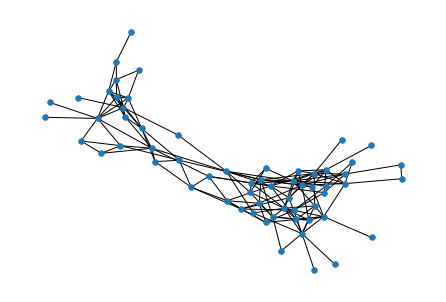

In [25]:
# constructing a networkx graph object
g = nx.Graph(A)

# drawing networkx graph
nx.draw(g,node_size=30)

And finally we use the second eigenvector to build the spectral partition (classifing the nodes din two groups basing the partition on the sign)

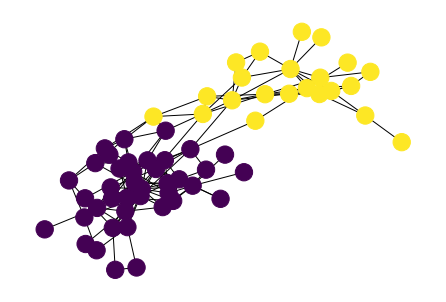

In [26]:
# define a partition and binarize the negative and positive eigenvector values
spectral_partition = second_eigenvector
spectral_partition[spectral_partition<0] = 0 
spectral_partition[spectral_partition>0] = 1

# draw the spectral partition
nx.draw(g, node_color=spectral_partition)

### 2.3.2

We implement the degree centrality

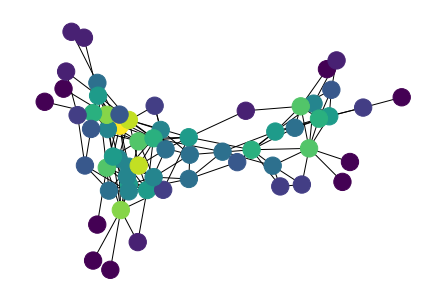

In [27]:
# compute the degree of the adjacency
degree = A.sum(axis=1) 

# draw the degree distribution
nx.draw(g,node_color=degree)

We report the values 

In [51]:
print('degree centraility:',degree)

degree centraility: [ 6.  8.  4.  3.  1.  4.  6.  5.  6.  7.  5.  1.  1.  8. 12.  7.  6.  9.
  7.  4.  9.  6.  1.  3.  6.  3.  3.  5.  5.  9.  5.  1.  3. 10.  5.  1.
  7. 11.  8.  2.  8.  5.  6.  7.  4. 11.  2.  6.  1.  2.  7. 10.  4.  2.
  7.  2.  2.  9.  1.  5.  1.  3.]


We implement the eigenvector centrality

In [37]:
from scipy.sparse import linalg

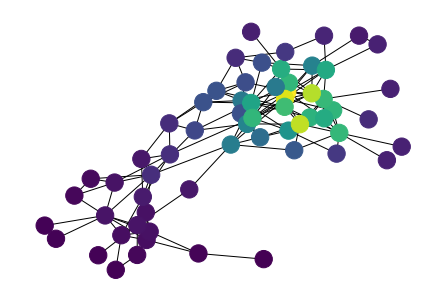

In [157]:
# compute the eigenvector associated with the largest eigenvalue
eigenvalue, eigenvector = linalg.eigsh(A, 1, which="LM", return_eigenvectors=True) 
# draw the eigenvector centrality
nx.draw(g,node_color=eigenvector)


We report the values

In [158]:
print('eigenvector centraility:',eigenvector.reshape(62,))

eigenvector centraility: [0.12850353 0.04207615 0.03975712 0.07933476 0.02928739 0.00655926
 0.01219126 0.04290099 0.14310214 0.01219738 0.07525347 0.02928739
 0.03907614 0.01500469 0.31578285 0.16417581 0.20799426 0.01751244
 0.20249469 0.02067478 0.18447739 0.2073514  0.00243444 0.08736214
 0.19321357 0.00594605 0.00894396 0.01631719 0.0682235  0.21176308
 0.04074725 0.00243444 0.00385593 0.28109869 0.13882809 0.02943765
 0.1327621  0.30056205 0.19661764 0.02087104 0.20787191 0.01524357
 0.0809501  0.19033934 0.07780237 0.28500522 0.02971651 0.08037062
 0.00241549 0.02342975 0.21769179 0.21068221 0.12956429 0.03368693
 0.02300201 0.05210983 0.00260655 0.01737613 0.02733225 0.11181862
 0.00053602 0.0519914 ]


Let's now proceed with PageRank, which can be done solving the following:

$
c_{PR} = \alpha (AD^{-1})  c_{PR} + (1 - \alpha) \frac{ 1}{N} 
$

The parameter $\alpha$ is taken equal to $0.85$ and $N$ is the number of nodes

Let's implement it in the following function

In [43]:
def pagerank(A):
    """implementing cpr solving the equation given before"""
    n = len(A) #number of nodes   
    I = np.eye(n) #identity matrix 
    # define diagonal matrix of node degrees
    weighted_degree = A.sum(axis=1) 

    # create diagonal matrix of degree
    D = np.diag(weighted_degree)
    
    #We build the matrx AD^-1
    B = np.dot(A,np.linalg.inv(D))
    
    k = (1-0.85)/n #alpha is 0.85
    
    page_rank = np.linalg.solve(I-0.85*B, k*np.ones(n))
    
    return page_rank

    

We implement the code

In [44]:
cpr = pagerank(A)

And report the values

In [53]:
print('page-rank centraility:',cpr)

page-rank centraility: [0.01696539 0.02465072 0.01333808 0.00962906 0.0050798  0.01442805
 0.02005363 0.01564303 0.0170983  0.02345848 0.0151084  0.0050798
 0.00483532 0.02615688 0.03214449 0.01988308 0.01662682 0.03172814
 0.01939555 0.0129282  0.02464092 0.01693899 0.0054159  0.0098635
 0.01690576 0.01150422 0.01121014 0.01713009 0.01484574 0.02645855
 0.0153021  0.0054159  0.01330868 0.02842307 0.01591994 0.00491822
 0.02061339 0.02987534 0.02393924 0.00776475 0.02196637 0.01613757
 0.01761865 0.02169113 0.01283083 0.0295142  0.0088259  0.01733952
 0.0052617  0.00887675 0.01923194 0.03129936 0.01207259 0.00818105
 0.02165088 0.00749417 0.00832625 0.03009537 0.0049629  0.01476792
 0.00619015 0.01103919]


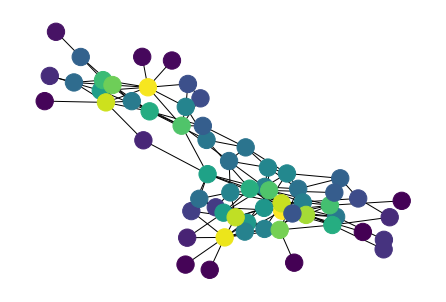

In [54]:
# draw the page rank centrality
nx.draw(g,node_color=cpr)

We print the highly central nodes, using pagerank, eigenvector and degree

In [175]:
print('5 most highly central nodes using pagerank= ',(-cpr).argsort()[:5]) 

5 most highly central nodes using pagerank=  [14 17 51 57 37]


In [176]:
print('5 most highly central nodes using eigenvector= ',(-eigenvector.reshape(62,)).argsort()[:5]) 

5 most highly central nodes using eigenvector=  [14 37 45 33 50]


In [177]:
print('5 most highly central nodes using degree= ',(-degree).argsort()[:5])

5 most highly central nodes using degree=  [14 37 45 33 51]


We can see how the first node (in 'centrality order') is always 15 and that for degree and eigenvector we get really similar results for the first 4 nodes. Pagerank is. little bit different, but if we prin the first 7 (or in general more elements) we see how in general the high central nodes are similar between the methods, even if sometimes in different order

In [166]:
print('5 most highly central nodes using pagerank= ',(-cpr).argsort()[:7]+1) 

5 most highly central nodes using pagerank=  [15 18 52 58 38 46 34]


Now we plot the various centralities (so eigenvector vs pagerank and so on).
We can already notice (from the plots) a quite good correlation (which becomes to be excellent between degree and pagerank)

Text(0.5, 0, 'pagerank')

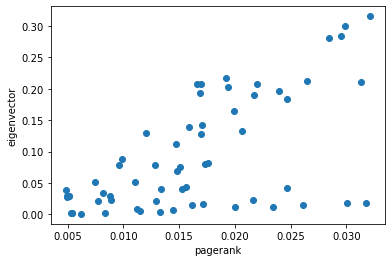

In [167]:
import matplotlib.pyplot as plt
plt.scatter(cpr,eigenvector)
plt.ylabel('eigenvector')
plt.xlabel('pagerank')

Text(0.5, 0, 'pagerank')

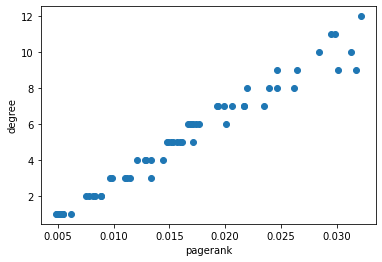

In [75]:
plt.scatter(cpr,degree)
plt.ylabel('degree')
plt.xlabel('pagerank')

Text(0.5, 0, 'eigenvector')

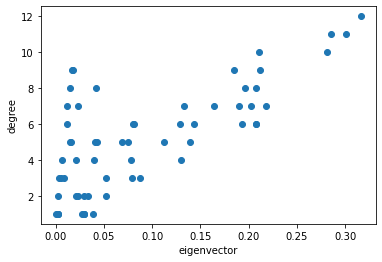

In [74]:
plt.scatter(-eigenvector,degree)
plt.ylabel('degree')
plt.xlabel('eigenvector')

We calculate the pearson coefficient to calculate the correlation

In [168]:
import scipy.stats
corr1 = scipy.stats.pearsonr(cpr,eigenvector.reshape(62,))[0]

In [170]:
print('pearson coefficient for the correlation between pagerank and eigenvector = ' ,corr1)

pearson coefficient for the correlation between pagerank and eigenvector =  0.6094173321392826


In [171]:
corr2 = scipy.stats.pearsonr(cpr,degree)[0]

In [172]:
print('pearson coefficient for the correlation between pagerank and eigenvector = ',corr2)

pearson coefficient for the correlation between pagerank and eigenvector =  0.9830947647309218


In [173]:
corr3 = scipy.stats.pearsonr(eigenvector.reshape(62,),degree)[0]

In [174]:
print('pearson coefficient for the correlation between pagerank and eigenvector = ',corr3)

pearson coefficient for the correlation between pagerank and eigenvector =  0.7196477408935361


We can see how we have always a correlation higher than 0.6, but for pagerank vs eigenvector it is 0.98, which is an excellent result. This means that we can use both pagerank and eigenvector almost interchangeably

The reason why the correlation is not so high for the other two comparisons (so there are some differences) could be searched in the structure of the nodes and in the meaning of the different centralities.

In particular degree centrality is based on the number of connections, while eigenvector centrality on the 'importance' of the connections. So this means that when we find nodes with high scores in the context of degree correlation, but with low scores in the context of eigenvector correlation we are dealing with nodes with a lot of connection, but with 'non-important' ones. On the other hand in the opposite situation we could have nodes with important connections, but only a few connection. On the other hand pagerank could be seen as a slight modification of the eigenvector centrality which considers both the factors (importance and number of connections) and so borderline situations as the one described before may occure and produce differences

Now we try to find out the names of the 'central' dolphins. For example following the pagerank centrality the main nodes are 14 and 17, which are as we can see (following code) are Grin and Jet

In [196]:
print('central dolphins according pagerank centrality are', names.iat[14,1],'and',names.iat[17,1])





central dolphins according pagerank centrality are Grin and Jet


According eigenvector and degree centrality the central nodes are 14 and 37, corresponding to Grin and SN4

In [197]:
print('central dolphins according eigenvector and degree centrality are', names.iat[14,1],'and',names.iat[37,1])



central dolphins according eigenvector and degree centrality are Grin and SN4


From the given article 'The bottlenose dolphin community of Doubtful Sound features a large proportion of long-lasting associations' we can easily say why Grin is the most central dolphin. As a matter of fact we can see that it has a lot of connections and is connected with dolphins like haeksel or scabs, who have a lot of connections too (and so are important)

We can see how Grin and SN4 are in the second group, while Jet is in group 3. This makes sense since the first group is the less connected one

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 Non-Negative Matrix Factorization (NMF) for dimensionality reduction  [^](#outline)

### 3.1.1

In [23]:
import tensorflow as tf
import tensorflow as tf
import tensorflow.keras as keras
#We import the data 
def load_data():
 (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
 x_train = x_train.astype('float32') / 255
 x_test = x_test.astype('float32') / 255
 # convert labels to categorical samples
 y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
 y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
 return ((x_train, y_train), (x_test, y_test))
(x_train, y_train), (x_test, y_test) = load_data()

I select the first 1000 samples

In [33]:
X_31 = x_train[:1000]
X_31.shape

(1000, 28, 28)

In [34]:
import numpy as np
X_train = []
for i in range(X_31.shape[0]):
    X_train.append(X_31[i].flatten())

#I want to exploit numpy, so I store them as numpy arrays

X_train = np.array(X_train)

In [35]:
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

x_bar = standardise(X_train)

In [36]:
# normalise min max to 0-1
def normalize_nmf(X):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X)) 
    return X_norm

X = normalize_nmf(x_bar)

In [52]:
X

array([[0.07227239, 0.07102598, 0.07111487, ..., 0.06815203, 0.06966493,
        0.07118262],
       [0.07227239, 0.07102598, 0.07111487, ..., 0.06815203, 0.06966493,
        0.07118262],
       [0.07227239, 0.07102598, 0.07111487, ..., 0.06815203, 0.06966493,
        0.07118262],
       ...,
       [0.07227239, 0.07102598, 0.07111487, ..., 0.06815203, 0.06966493,
        0.07118262],
       [0.07227239, 0.07102598, 0.07111487, ..., 0.06815203, 0.06966493,
        0.07118262],
       [0.07227239, 0.07102598, 0.07111487, ..., 0.06815203, 0.06966493,
        0.07118262]], dtype=float32)

In [57]:
# choosing the number of dimensions on which to project
k = 2

# setting the random seed (just so everyone gets the same results...)
np.random.seed(0)

# m x k components matrix, usually interpreted as the coefficients, where m is the number of data
W = np.random.rand(X.shape[0], k)

# k x n matrix interpreted as the basis set, where n is the number of features (e.g. pixels)
H = np.random.rand(k, X.shape[1])

In [58]:
# lets define a cost matrix to compare the difference
def cost(X,W,H):
  
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H) 

    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1])
    
    return chi2

In [59]:
# set the number of iterations
n_iters = 700

# empty list for chi2 
chi2 = []

# loop over the n iterations
for i in range(n_iters):

    # compute the update on H
    H = H * ((W.T.dot(X)) / W.T.dot(W.dot(H))) 

    # compute the update on W
    W = W * ((X.dot(H.T)) / (W.dot(H.dot(H.T)))) 

    # compute the chi2 and append to list
    chi2.append(cost(X,W,H))

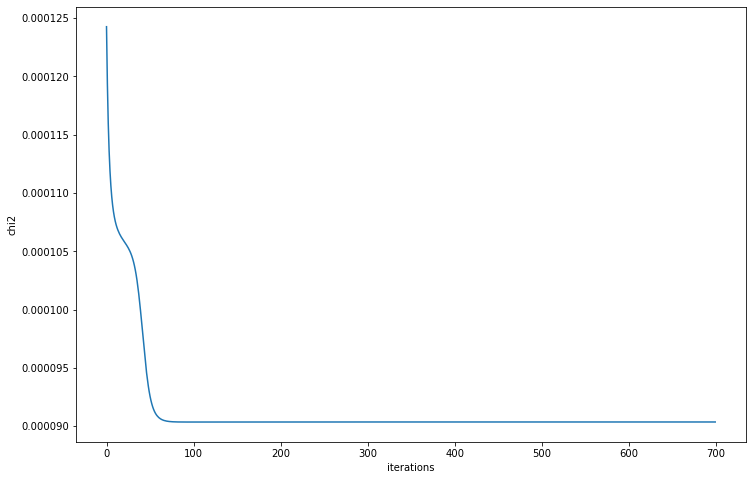

In [64]:
import matplotlib.pyplot as plt
# plotting the cost
plt.figure(figsize=(12,8))
plt.plot(chi2)
plt.xlabel('iterations')
plt.ylabel('chi2')
plt.show()

### 3.1.2

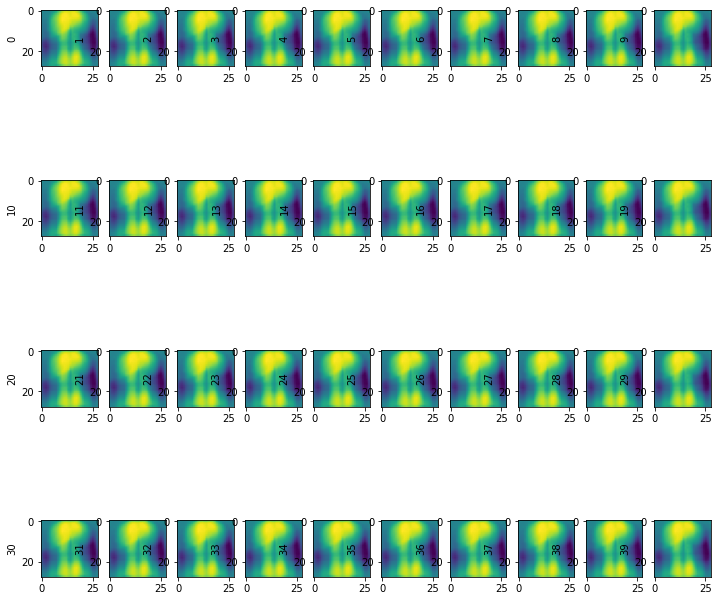

In [194]:
nrow = 4; ncol = 10;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(12,12))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(np.dot(W,H)[4,:].reshape([28,28]))
    ax.set_ylabel(str(i))




<a name="q32"></a>

## 3.2 Community detection [^](#outline)

### 3.2.1

In [92]:
A = np.load('dolphins_A_62x62.npy')
F = np.load('dolphins_F_62x32.npy')

In [94]:
import networkx as nx

In [129]:
g1 = nx.Graph(A) #graph

We use the built in networkx function implementing the louvain algorithm, to obtain the communities

In [155]:
#obraining the communities using the louvain algorithm
louvain = nx.algorithms.community.louvain_communities(g1)
louvain=np.array(louvain)
louvain

array([{35, 4, 11, 45, 15, 18, 51, 23, 21, 55, 24, 29},
       {0, 2, 19, 10, 7, 42, 30, 47},
       {32, 1, 5, 6, 9, 41, 13, 48, 17, 22, 54, 56, 57, 26, 27, 60, 25, 31},
       {3, 36, 39, 8, 59, 28},
       {33, 34, 37, 38, 40, 43, 44, 12, 14, 46, 16, 49, 50, 20, 52, 53, 58, 61}],
      dtype=object)

I notice that I have 5 communities and I associate each community to a number (so that we can draw the graph with different colours for each community)

In [156]:
colorset = []

for j in range(62):
    if j in louvain[0]:
        colorset.append(0)
    elif j in louvain[1]:
        colorset.append(1)
    elif j in louvain[2]:
        colorset.append(2)
    elif j in louvain[3]:
        colorset.append(3)
    elif j in louvain[4]:
        colorset.append(4)

We draw the graph such that the nodes in the same community have the same color

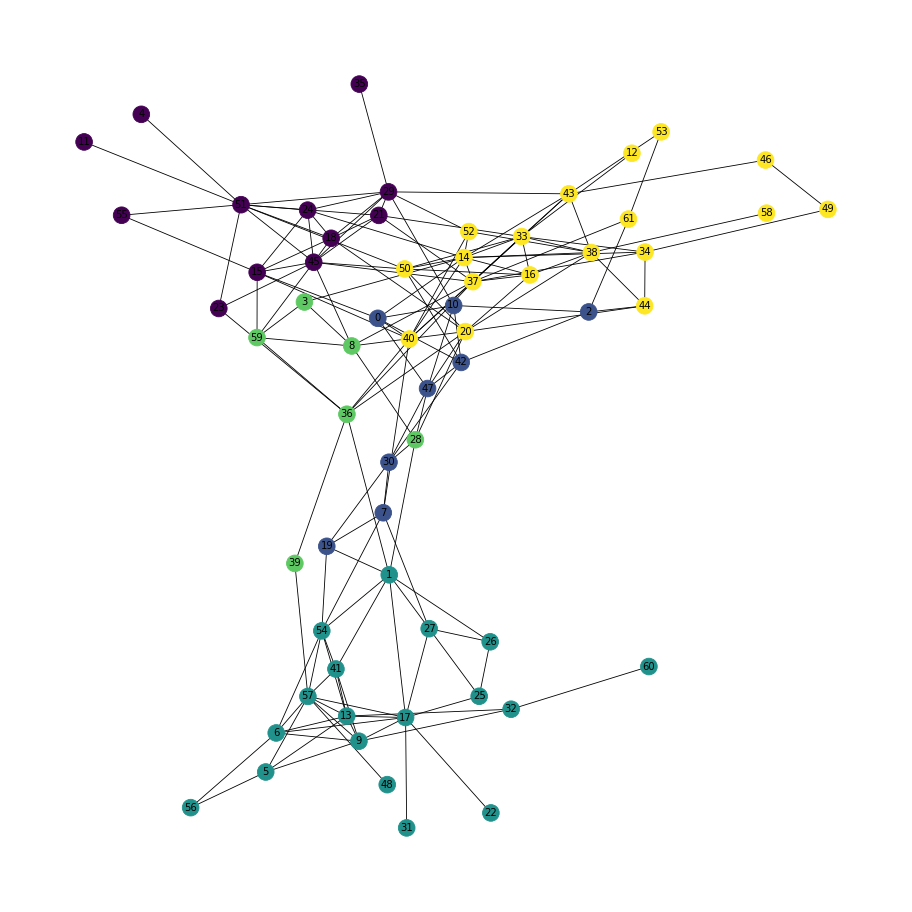

In [162]:
fig = plt.figure(1, figsize=(15, 15), dpi=60)
nx.draw(g1,node_size=400,node_color = colorset,with_labels=True)

Let's enumerate the communities to make the analysis easier. (note that we are just assigning a name/number to each community)

In [163]:
for i in range(5):
    print('Community',i,'=',louvain[i])

Community 0 = {35, 4, 11, 45, 15, 18, 51, 23, 21, 55, 24, 29}
Community 1 = {0, 2, 19, 10, 7, 42, 30, 47}
Community 2 = {32, 1, 5, 6, 9, 41, 13, 48, 17, 22, 54, 56, 57, 26, 27, 60, 25, 31}
Community 3 = {3, 36, 39, 8, 59, 28}
Community 4 = {33, 34, 37, 38, 40, 43, 44, 12, 14, 46, 16, 49, 50, 20, 52, 53, 58, 61}


In 2.3.2 using eigenvector measure of centrality the most central nodes are = [14,37,45,33,50], which are in the communities = [4,4,0,4,4]. So we can see how we have a concentration of highly central (according pagerank measure) dolphins in the 4th community.


Using the pagerank measure of centrality the most central nodes are = [14,17,51,57,37], which are in the communities [4,2,0,2,4]. So we can see how also in this case we have an high concentration of central dolphins on the 4th (but also 2nd) community.


Finally using degree measure of centrality the most central nodes are = [14,37,45,33,51], which are in the communities = [4,4,0,4,0]. We can still notice the importance of the 4th community and now also a certain relevance of the community 0.

So the main thing we can conlude is that none of the central dolphin according the three centralities is in community 1 or 3 (which we can see being the ones with less elements), while the other 3 communities seem to be always relevant according each measure. In particular the 4th community has a 'leading role', which can be seen also by the presence of the 'most central' dolphin 14, which we can also easily identify in the middle of our graph (We can see how it is connected with other 3 central points (50,33 and 37).

### 3.2.2

Now we consider the levels of ex 2.2 from the coarsest to the finest (so increasing number of clusters for increasing level)

In [170]:
acl

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [122., 122., 122., ..., 122., 122., 122.],
       [121., 117., 121., ..., 121., 117., 121.],
       ...,
       [  0.,   1.,   2., ...,  59.,  60.,  61.],
       [  0.,   1.,   2., ...,  59.,  60.,  61.],
       [  0.,   1.,   2., ...,  59.,  60.,  61.]])

In [172]:
from sklearn.metrics import adjusted_rand_score

In [190]:
Adjusted_Rand_Index_scores = []
for j in range(61):
    Adjusted_Rand_Index_scores.append(adjusted_rand_score(acl[j],colorset))
    print('ARI at level ',j, '= ',adjusted_rand_score(acl[j],colorset))

ARI at level  0 =  0.0
ARI at level  1 =  0.0
ARI at level  2 =  0.3430834433405128
ARI at level  3 =  0.6802548878464489
ARI at level  4 =  0.7927321782386915
ARI at level  5 =  0.7429788069844637
ARI at level  6 =  0.7971905530350457
ARI at level  7 =  0.6741138635122308
ARI at level  8 =  0.5803840897510988
ARI at level  9 =  0.5710806504008781
ARI at level  10 =  0.5482999564987726
ARI at level  11 =  0.5649556986168844
ARI at level  12 =  0.5537845632575681
ARI at level  13 =  0.5149710059875816
ARI at level  14 =  0.5025629810425025
ARI at level  15 =  0.4773349993585525
ARI at level  16 =  0.4224955365151502
ARI at level  17 =  0.37892925812822453
ARI at level  18 =  0.38027069489825804
ARI at level  19 =  0.3521982373565415
ARI at level  20 =  0.3436480968498593
ARI at level  21 =  0.33215387588376016
ARI at level  22 =  0.32055078835488804
ARI at level  23 =  0.32316833100683634
ARI at level  24 =  0.31731780439184415
ARI at level  25 =  0.308489630860665
ARI at level  26 =  0

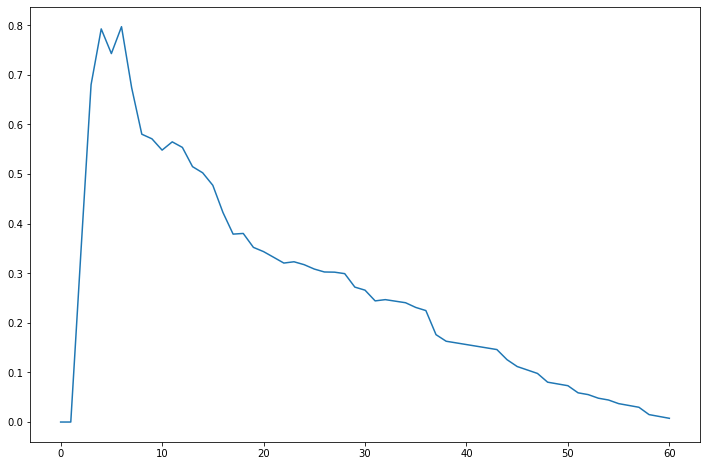

In [188]:
plt.figure(figsize=(12,8))
plt.plot(Adjusted_Rand_Index_scores)

We see that the best ARI scores for the levels between 4 and 7, with a peak equal to 0.7971905530350457 for the sixth level. This what we would expect because the number of the clusters is comparable with the number of communities we got with the louvain algorithm.


The 'homophily principle in social networks' is a concept reletad to the tendency of elements in a network to be related to similar individuals. This makes sense in our context, where the dolphins seem to be having social interactions mainly with individuals of the 'same social group'
